# Urban spatial structure: the Mumbai example 

In this notebook we show how to extract information on the daily commuting patterns of people starting from raw location based mobility data.

Specifically we start by loading raw data, we then filter them and observe the main features of the data (from both a collective and user based perspective).

We conduct all of our anlyses tessellating our area of interest with an hexagonal grid (with a side of about 450m).

For each grid cell we then infer some key observables linked to the users' mobility patterns, that is:
- its land use (i.e., the predominant vocation);
- the number of residents (workers) whose home (workplace) falls within the cell;
- the average distance, time and speed of commuting for people residing there.

We will save the checkpoints of the procedure to speed up following refinements of the procedure.

We start with some generic imports to facilitate our analyses.

**Note on data**

The data used in this notebook have been provided by [Quadrant](https://www.quadrant.io/) within the **Resilient Urban Planning Analysis Using Smartphone Location Data** project of the The World Bank / Global Facility for Disaster Reduction and Recovery ([GFDRR](https://www.gfdrr.org/en)) - contract number 7204724.

[Quadrant](https://www.quadrant.io/) (An Appen Company) is a global leader in mobile location data, POI data, and corresponding compliance services.  Quadrant provides anonymised location data and location-based business solutions that are fit for purpose, authentic, easy to use, and simple to organise. We offer data for almost all countries in the world, with hundreds of millions of unique devices and tens of billions of events per month, allowing our clients to perform location analyses, derive location-based intelligence, and make well-informed business decisions. Our data is gathered directly from first party opt-in mobile devices through a server-to-server integration with trusted publisher partners, delivering genuine and reliable raw GPS data unlike other location data sources relying heavily on Bidstream. Our consent management platform, QCMP, ensures that our data is compliant with applicable consent and opt-out provisions of data privacy laws governing the collection and use of location data.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from datetime import datetime
import sys
import os
from shutil import rmtree
from dask.distributed import Client
from dask import dataframe as dd
import dask
import seaborn as sns
import statsmodels.api as sm
import pytz
import psutil
import multiprocessing
sns.set_context('notebook', font_scale=1.5)

dask.__version__

'2022.04.1'

We also import `mobilkit` as `mk` to gain access to all the librarie's capabilities.
We import some constant names of columns from the `dask_schemas` submodule as they will be useful later on.

In [2]:
import mobilkit as mk
from mobilkit.spatial import haversine_pairwise
from mobilkit.dask_schemas import (latColName, lonColName,
                                   uidColName, zidColName,
                                   accColName, utcColName,
                                   dttColName, durColName,
                                   locColName, ldtColName,
                                   medLatColName, medLonColName)
from mobilkit.viz import compareLinePlot

## Configuration

Here we need to specifiy the details of our analysis, such as where the input files are found and the name to give to our analysis.

We also set some variables needed to localize the timestamps, compute home and work locations and correctly compute the distances in the local projection.

### Analysis input

In [3]:
# The name of the subfolder in the output folder where to put checkpoints and
# save results
city_name = 'mumbai'
# The timezone to use to pass from timestamp to datetime
timezone = 'Asia/Kolkata'

# We limit the analysis to this date range
start_date = datetime(2022,  2, 28)
end_date   = datetime(2022,  4,  1)

# The hours to count as home and work:
# We set the initial and final time in 24h format using a float notation
# For instance 17:45 is 17.75
homeHours=(22, 8)
workHours=(10,18)

# This is the grid file to be used to tessellate data 
aoi_grid_file = 'data/AOI_bbox/aoi_Mumbai_GRID.geoJSON'

### Spatial details

In [4]:
# The local projection to us when buffering the home and offices (to compute
# their approximated density), together with the city center
local_EPSG = 24381
homeWorkBufferMeters = 500
center_of_city = np.array([18.928453,72.829736]).reshape(1,2)

# When dealing with a policentric city we may want to specify the different
# business districts of the city
multiple_cbd_latlon = np.array([
        [18.928453,72.829736], # Central Business District,
        [19.013895,72.837438], # Extended Business District,
        [19.067498,72.865451], # New Business District,
        [19.165406,72.858306], # Suburban Business District (west),
        [19.151227,72.954612], # Suburban Business District (east),
        [19.054251,73.027987], # Peripheral Business District (Navi Mumbai),
        [19.216505,72.977984], # Peripheral Business District (Thane),
        [19.255434,73.046656], # Bhilwara Town,
])

# Custom stop detection keyowrds that will be passed to mk.spatial.findStops
# See the function's documentation for details.
custom_stay_locations_kwds = {
    'minutes_for_a_stop': 10.0,
    'spatial_radius_km': 0.2,
    'no_data_for_minutes': 60*10,
}

### Running options

In [5]:
# If True it will recompute all the checkpoints (if already present)
recomputeAll = False

# The raw files' pattern are and where to save the results/output.
RAW_FILES_PATTERN = '/mnt/data_two/mob_data/IN_mumbai/year=*/month=*/day=*/*_*_*_*_bucket-*'
OUT_ROOT_FOLDER  = '/mnt/data/resilience_analyses'

### OSRM backend

Here, if we also want to compute "theoretical" commuting times and distances, we set the details of the [Open Source Routing Machine](http://project-osrm.org/).

Thanks to its dockerized implementation, it is pretty straightforward to set up a local OSRM server by following the instructions of the [OSRM Backend](https://github.com/Project-OSRM/osrm-backend).

You start by downloading the OpenStreetMaps databse for your area of interest from [GeoFabrik](http://download.geofabrik.de/).
```
wget http://download.geofabrik.de/europe/germany/berlin-latest.osm.pbf
```

Then, with the `osrm-cli` tools installed, prepare the data:
```
osrm-extract -p your_profile berlin.osm.pbf
osrm-partition berlin.osrm
osrm-customize berlin.osrm
```

Finally, run a docker container to be queried for routing duration/distances.
```
sudo docker run -t -i -p 5000:5000 -v "${PWD}:/data" osrm/osrm-backend osrm-routed --algorithm=MLD /data/berlin-latest.osrm
```

In [6]:
# OSRM BACKEND CONFIG
max_trip_duration_s = 10800
# Compose the base query
SERVER = "http://localhost"
PORT = 5000
PROFILE = "car"

osrm_url = f"{SERVER}:{PORT}/table/v1/{PROFILE}/"

## Start of computation

We start by creating the output folders and loading the needed shapefiles and datasets.

In [7]:
# Create the output folders and path
OUT_DIR = os.path.join(OUT_ROOT_FOLDER, city_name)
os.makedirs(OUT_DIR, exist_ok=True)
out_grid_cells_file = os.path.join(OUT_DIR, 'gdf_landuse_rog.gpkg')
OUT_DIR_FIG = os.path.join(OUT_DIR, 'figures')
os.makedirs(OUT_DIR_FIG, exist_ok=True)

### Load grid
Read the grid's geo-dataframe and project it to the local projection.
We also plot the distribution of the area (in $km^2$) for the regular grid we selected to check it is regular.

Grig mean sqkm 0.4871392896713538 and median 0.48713928967140174


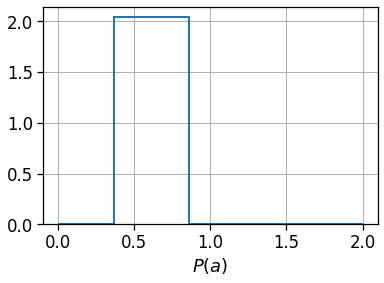

In [9]:
gdf_aoi_grid = gpd.read_file(aoi_grid_file)
gdf_aoi_grid_local = gdf_aoi_grid.to_crs(epsg=local_EPSG)

(gdf_aoi_grid_local.area/1e6).hist(bins=np.geomspace(.001, 2, 10),
                                   density=True,
                                   histtype='step',
                                   lw=2,
                                   label='Hex Grid'
                                  )
plt.xlabel(r'Cell area ($km^2$) - $a$')
plt.xlabel(r'$P(a)$')

print('Grig mean sqkm',
      (gdf_aoi_grid_local.area/1e6).mean(),
      'and median', (gdf_aoi_grid_local.area/1e6).median())

### Create _Dask_ client

Here we create and connect to a dask client.
We just specify where we want Dask to store tmp files (the `tmp_dask_dir`) and the memory limit per worker.

In [8]:
tmp_dask_dir = '/mnt/dask_workplace/'
dask.config.set({'temporary_directory': tmp_dask_dir})
os.environ["DASK_TEMPORARY_DIRECTORY"] = tmp_dask_dir

In [9]:
n_proc = int(multiprocessing.cpu_count() / 2) - 1
mem_per_proc = psutil.virtual_memory().total * 1.3 / 1e9 / n_proc
client = Client(
    memory_limit='%.01fG'%mem_per_proc,
    n_workers=n_proc,
    threads_per_worker=2
               )
client

/home/enrico/.local/share/virtualenvs/jupyter-EWzvnNR1/lib/python3.8/site-packages/distributed/node.py:177: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41527 instead
  warnings.warn(
2022-05-17 16:40:06,600 - distributed.diskutils - INFO - Found stale lock file and directory '/mnt/dask_workplace/dask-worker-space/worker-8g5lkup8', purging
2022-05-17 16:40:06,600 - distributed.diskutils - INFO - Found stale lock file and directory '/mnt/dask_workplace/dask-worker-space/worker-2e1e4vyf', purging
2022-05-17 16:40:06,601 - distributed.diskutils - INFO - Found stale lock file and directory '/mnt/dask_workplace/dask-worker-space/worker-yfmqukvb', purging
2022-05-17 16:40:06,601 - distributed.diskutils - INFO - Found stale lock file and directory '/mnt/dask_workplace/dask-worker-space/worker-7qz48yox', purging
2022-05-17 16:40:06,601 - distributed.diskutils - INFO - Found stale lock file and directory '/mnt/dask_workpla

<Client: 'tcp://127.0.0.1:34233' processes=23 threads=46, memory=162.80 GiB>

### Load raw data

We use the `dask.dataframe.read_parquet` to easily read the raw data.

Then we leverage on the `mk.loader.compute_datetime_col` to localize the timestamp to out selected timezone `timezone`.

We also compute a `day` column that will be used to partition the output files.

In [10]:
df_raw = dd.read_parquet(RAW_FILES_PATTERN)

In [11]:
df = df_raw.dropna(how='any',
                   subset=['timestamp','quad_id',
                           'latitude','longitude',
                           'horizontal_accuracy'])\
            .query('horizontal_accuracy<=70')

df[utcColName] = df['timestamp']/1000
df = mk.loader.compute_datetime_col(df, selected_tz=pytz.timezone(timezone))

df = df.rename(columns={
    'latitude': latColName,
    'longitude': lonColName,
    'quad_id': uidColName,
    'horizontal_accuracy': accColName
})

df = df[
    (df[dttColName] >= start_date)
    & (df[dttColName] < end_date)
][[dttColName, latColName, lonColName,
   uidColName, utcColName, accColName]].copy()

df['day'] = df['datetime'].dt.floor('1d').dt.strftime('%Y%m%d')
df.head(0)

Empty DataFrame
Columns: [datetime, lat, lng, uid, UTC, acc, day]
Index: []

### Filter date range
We filter the raw pings to be within the selected time range.

In [12]:
df_pings = df[df[dttColName].between(start_date,end_date)].copy()

### Computing users and pings count
To check the temporal dependence of the number of pings and/or users per day we can use the `mk.temporal.computeVolumeProfile`. The latter returns the daily volume of active pings/users seen in the dataset.
To get a normalized (0-1) count simply pass `normalized=True` to the function.

As one can see, the volume of daily users and pings is highly volatile, so that we have to apply normalization techniques in the following, for instance when computing land use.

In [16]:
path_ping_user_volume

'/mnt/data/resilience_analyses/mumbai/ping_users_volume.pkl'

In [17]:
!rm /mnt/data/resilience_analyses/mumbai/ping_users_volume.pkl

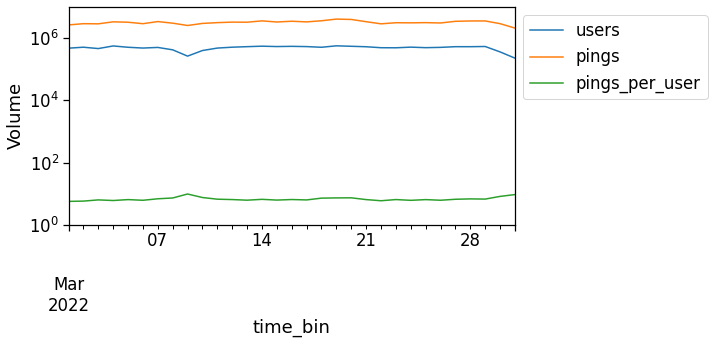

In [22]:
path_ping_user_volume = os.path.join(OUT_DIR, 'ping_users_volume.pkl')
if recomputeAll and os.path.exists(path_ping_user_volume):
    os.remove(path_ping_user_volume)
if not os.path.exists(path_ping_user_volume):
    df_volume = mk.temporal.computeVolumeProfile(df_pings, what='both', normalized=False)
    pd.to_pickle(df_volume, path_ping_user_volume)
fig, ax = plt.subplots(1,1,figsize=(8,4))
df_volume = pd.read_pickle(path_ping_user_volume)
df_volume.plot(ax=ax)
plt.semilogy()
plt.ylim(1e0, 1e7)
plt.ylabel('Volume')
plt.legend(loc=2, bbox_to_anchor=[1,1])
plt.savefig(os.path.join(OUT_DIR_FIG, 'user_ping_volume.pdf'))

### Select valid users
Another important task is to check the representativeness of users.
As we might have users that features too few pings (or that are seen only for one-two days), we want to focus the analysis on the users featuring a rich statistics.

To this end, we first compute the users' stats using `mk.stats.userStats`. The latter computes, for each user:
- his number of raw pings;
- the number of spanned days (i.e., the number of days between their first and last appearance of the user in the dataset);
- the number of active days (i.e., the number of different days that the user has been active).

To visualize the impact of the threshold we apply on these counters, we can use the `mk.stats.plotUsersHist` function, that plots for us a nive 2d-histogram outlining the distribution of the users' number of pings, days, etc, plus the counters of users in the upper-left (ul) part of the histgram and so on.

In [14]:
path_users_stats = os.path.join(OUT_DIR, 'users_stats.pkl')
if recomputeAll and os.path.exists(path_users_stats):
    os.remove(path_users_stats)
if not os.path.exists(path_users_stats):
    users_stats_df = mk.stats.userStats(df_pings).compute()
    pd.to_pickle(users_stats_df, path_users_stats)
users_stats_df = pd.read_pickle(path_users_stats)
users_stats_df.head(0)

Empty DataFrame
Columns: [uid, min_day, max_day, pings, daysActive, daysSpanned, pingsPerDay, avg]
Index: []

In [15]:
# Select the threshold of minimum pings and active days for a user to be kept
min_user_pings = 100
min_user_days = 5

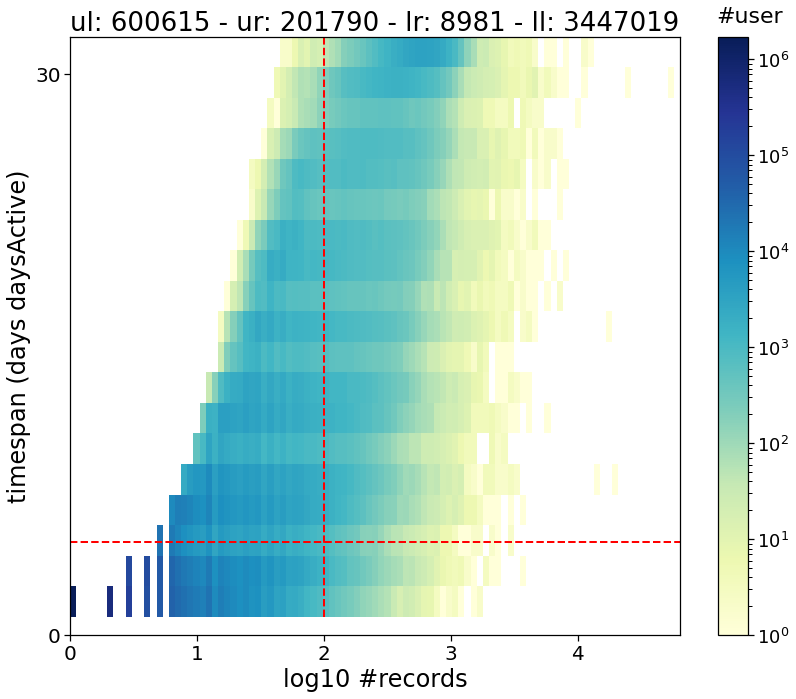

In [16]:
mk.stats.plotUsersHist(users_stats_df,
                             min_pings=min_user_pings,
                             min_days=min_user_days)
plt.savefig(os.path.join(OUT_DIR_FIG, 'user_2dhist.pdf'))

In [17]:
valid_users = list(users_stats_df.query("daysActive >= @min_user_days & pings > @min_user_pings")["uid"])
df_pings_filtered = mk.stats.filterUsersFromSet(df_pings,
                                                users_set=valid_users)

## Compute the needed tables

We will first compute all the event tables needed. These are:
- the `stops_df_tessellated` where we transform raw pings in users' stops (i.e., stays of users long at least x minutes and localized in space);
  these stops also feature a duration, that is, an initial and final datetime. Also, each stop is assigned to a grid cell by looking at its mean point. To find the stops we leverage the traditional method of:
  > [Hariharan, R. & Toyama, K. Project Lachesis: Parsing and Modeling Location Histories.](https://doi.org/10.1007/978-3-540-30231-5_8),
  > in Geographic Information Science 106–124 (Springer Berlin Heidelberg, 2004),
  
  that is, we look for groups of pings close enough in space for at least a given duration to be labelled as stops.
  `mobilkit` leverages on the stop-detection implementation of `scikit-mobility` under the hood, conveniently parallelizing the per-user stop-detection work.
- the `exploded_stops_df` contains the same information but each stop is replicated once for every hour that it touches. For instance, a stop starting
  at 09:12 and ending at 11:06 will be replicated at 09:12, 10:12, 11:12, so that we have an idea of the users and number of stops found in each area at each moment of the day.
- then we compute the user locations, i.e., we group the stops close enough in meaningful locations. These will be encoded in the `users_stop_locs_df`
  that contains and additonal column `loc_ID` telling the location id of the stop and the `lat_medoid,lng_medoid` columns, containing the latitude and
  longitude of the medoid (i.e., the real stop point that minimizes the sum of distances to the other stops of the group).
  Again, in the default implementation we use the DBSCAN method as suggested in the *Project Lachesis*. An alternative solution is to use the `infostop` method as described in:
  > Aslak, U. & Alessandretti, L. Infostop: Scalable stop-location detection in multi-user mobility data. (2020).
  > [arXiv 2003.14370](https://arxiv.org/pdf/2003.14370.pdf).
- the `user_locs_stats_hw_separated` will contain the home and work hours stats of each location, such as the number of hours that the user spent there,
  how many times we have seen him at the location for each single hour in the night and day hour ranges.
  Also, the fraction of day/night hours during which the location was the most visited (both in terms of stop duration and count) are reported.
  The procedure is as found in   
> Lenormand, M., Louail, T., Barthelemy, M. & Ramasco, J. J. Is spatial information in ICT data reliable?
> [arXiv 1609.03375](http://arxiv.org/abs/1609.03375) (2016).
- the `df_hw_locs_pd` table is a compressed, wide format table reporting, for each user, its home and work location stats and coordinates. It will be
  used in the following to compute the spatial and per-user statistics.

### Compute stops and locations

The whole procedure to pass from users' pings to stops and locations is represented below (data from the Microsoft's GeoLife dataset). 

![Figure describing the procedure to extract stops and locations from raw pings. Data from a single user of the GeoLife Microsoft Dataset.](figures/pings_stops_locs.png "Figure describing the procedure to extract stops and locations from raw pings. Data from a single user of the GeoLife Microsoft Dataset.").

**A** We start with the user pings color-coded with their original time (from blue, eldest, to yellow, most recent).

**B** Stops (coloured big circles) are found when some pings are close enough in space (within 200 meters one to the others in our case) for at least a minimum duration of time (10 minutes in this example). Also in this case the time sptamp of the stops is color-coded to show that the user is coming back multiple times in different moments in one venue.

**C** The stops falling close enough (within 100 meters one to the other in this example) are then linked and clusters of stops are found using the DBSCAN algorithm. These groups of stops represent the venues (or typical locations) of the user.

**D** Finally, each location is mapped to its centroid (the black-bordered dots), i.e., the points that minimizes the distance with respect to all the other points of the cluster of stops.

### Compute stops

Here we start by computing the stops of the users and assigning them to a cell grid (tessellation).

We compute the stays using the `custom_stay_locations_kwds` argument.

```
custom_stay_locations_kwds = {
    'minutes_for_a_stop': 10.0,
    'spatial_radius_km': 0.2,
    'no_data_for_minutes': 600
}
```

In particular, we use the Project Lachesis method defined in
> Hariharan, R. & Toyama, K. Project Lachesis: Parsing and Modeling Location Histories.
> [In Geographic Information Science 106–124](https://doi.org/10.1007/978-3-540-30231-5_8) (Springer Berlin Heidelberg, 2004).

to extract the stops from the sequence of positions of the users. Specifically we define a stop when a user stays for at least 10 minutes in a radius of up to 200 meters. Moreover, we allow the data to have hole of up to 10 hours (meaning that if a user is seen at a location, no data are present during the next 10 hours max and then the user is still seen at the location we count the stop to be a valid one).

We also pass the reference to the shapefile to tessellate the stops location, i.e., assign each stop's centroid to a cell of the grid.

The resulting dataframe reports, for each stop, the latitude and longitude of the stop centroid, the start and end time of the stay and the user id plus the corresponding tile id.

In [18]:
stops_df_tessellated = mk.spatial.findStops(df_pings_filtered,
                                            tesselation_shp=aoi_grid_file,
                                            filterAreas=True,
                                            stay_locations_kwds=custom_stay_locations_kwds,
                                           )
stops_df_tessellated

/home/enrico/.local/share/virtualenvs/jupyter-EWzvnNR1/lib/python3.8/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


Dask DataFrame Structure:
                     lat      lng     uid        datetime leaving_datetime duration tile_ID
npartitions=310                                                                            
                 float64  float64  object  datetime64[ns]   datetime64[ns]  float64   int64
                     ...      ...     ...             ...              ...      ...     ...
...                  ...      ...     ...             ...              ...      ...     ...
                     ...      ...     ...             ...              ...      ...     ...
                     ...      ...     ...             ...              ...      ...     ...
Dask Name: getitem, 27855 tasks

In [19]:
# Code to save the dataframe to disk
path_stops_tessellated = os.path.join(OUT_DIR, 'dataHFLB_stops_tessellated_parquet')
if recomputeAll and os.path.exists(path_stops_tessellated):
    rmtree(path_stops_tessellated)
if not os.path.exists(path_stops_tessellated):
    stops_df_tessellated['day'] = stops_df_tessellated[dttColName].dt.floor('1d').dt.strftime('%Y%m%d')
    stops_df_tessellated.to_parquet(path_stops_tessellated,
                                    compression='gzip',
                                    write_index=False,
                                    partition_on='day',
                                    overwrite=True)
stops_df_tessellated = dd.read_parquet(path_stops_tessellated)

### Explode the stops

Some functions of `mobilkit` require a single ping (or stop) to be repeated multiple times at a given frequency, for instance to compute the visit profiles of areas.

Here we expand the stops falling in more than one hour to be repeated, i.e., the **exploded** stops.
This means that each stop instead of reporting the start and end time is duplicated once for every given interval the stop touches (in this case every hour).

This view is useful if we want to quickly compute the number of users found in a given area at a given hour.

In [20]:
exploded_stops_df = mk.spatial.expandStops(stops_df_tessellated,
                                           freq='1h',
                                           explode_stop=True)
exploded_stops_df

Dask DataFrame Structure:
                      lat      lng     uid        datetime duration tile_ID              day   stops
npartitions=9610                                                                                    
                  float64  float64  object  datetime64[ns]  float64   int64  category[known]  object
                      ...      ...     ...             ...      ...     ...              ...     ...
...                   ...      ...     ...             ...      ...     ...              ...     ...
                      ...      ...     ...             ...      ...     ...              ...     ...
                      ...      ...     ...             ...      ...     ...              ...     ...
Dask Name: expand_stops_partition, 19220 tasks

In [21]:
path_stops_exploded_tessellated = os.path.join(OUT_DIR, 'dataHFLB_stops_tessellated_exploded_parquet')
if recomputeAll and os.path.exists(path_stops_exploded_tessellated):
    rmtree(path_stops_exploded_tessellated)
if not os.path.exists(path_stops_exploded_tessellated):
    exploded_stops_df['day'] = exploded_stops_df[dttColName].dt.floor('1d').dt.strftime('%Y%m%d')
    exploded_stops_df.to_parquet(path_stops_exploded_tessellated,
                                    compression='gzip',
                                    write_index=False,
                                    partition_on='day',
                                    overwrite=True)
exploded_stops_df = dd.read_parquet(path_stops_exploded_tessellated)
exploded_stops_df = exploded_stops_df.repartition(npartitions=200)
exploded_stops_df.head(0)

Empty DataFrame
Columns: [lat, lng, uid, datetime, duration, tile_ID, stops, day]
Index: []

### Compute the users' locations
To detect the home and workplace of the users, we group their stops in meaningful locations.

Locations are clusters of stops (or stays) that are close enough to supposedly belong to one venue of the user. Home and work are the two most important ones but other locations can be found in a user's mobility diary.

`mobilkit` offers two ways to find locations:
- using a `dbscan` unsupervised clustering algorithm, as in the Lachesis project;
- using the `infostop` package, that groups the stops of a user by linking them in a weighted network.
> Aslak, U. & Alessandretti, L. Infostop: Scalable stop-location detection in multi-user mobility data.  [arXiv 2003.14370](https://arxiv.org/abs/2003.14370) (2020).

In the following we use the `dbscan` approach, where we link stops distant up to 100 meters and using clusters with a n=1 core.

The result is a dataframe reporting the latitude and longitude of the medoid of the locations of each user, plus a unique identifier of each location-user couple.

In [22]:
users_stop_locs_df = mk.spatial.computeUsersLocations(
                            stops_df_tessellated.repartition(npartitions=200),
                            method='dbscan',
                            link_dist=100,
                            min_stops_count=1,
                            return_locations=False)
users_stop_locs_df

Dask DataFrame Structure:
                 index      lat      lng     uid        datetime leaving_datetime duration tile_ID              day loc_ID lng_medoid lat_medoid
npartitions=200                                                                                                                                 
                 int64  float64  float64  object  datetime64[ns]   datetime64[ns]  float64   int64  category[known]  int64    float64    float64
                   ...      ...      ...     ...             ...              ...      ...     ...              ...    ...        ...        ...
...                ...      ...      ...     ...             ...              ...      ...     ...              ...    ...        ...        ...
                   ...      ...      ...     ...             ...              ...      ...     ...              ...    ...        ...        ...
                   ...      ...      ...     ...             ...              ...      ...     ...              ...    ...        ...        ...
Dask Name: reset_index, 18685 tasks

In [23]:
path_users_stop_locs = os.path.join(OUT_DIR, 'users_stop_locs_df')
if recomputeAll and os.path.exists(path_users_stop_locs):
    rmtree(path_users_stop_locs)
    
if not os.path.exists(path_users_stop_locs):
    users_stop_locs_df['day'] = users_stop_locs_df[dttColName].dt.floor('1d').dt.strftime('%Y%m%d')
    users_stop_locs_df.to_parquet(path_users_stop_locs,
                                    compression='gzip',
                                    write_index=False,
                                    partition_on='day',
                                    overwrite=True)
users_stop_locs_df = dd.read_parquet(path_users_stop_locs).repartition(npartitions=200)
users_stop_locs_df.head(0)

Empty DataFrame
Columns: [index, lat, lng, uid, datetime, leaving_datetime, duration, tile_ID, loc_ID, lng_medoid, lat_medoid, day]
Index: []

### Compute statistics on the users' locations

We compute the number of times a user visits each location, how long it stays there and for how many home- and work-time hours we observe him at the location.

Following *Lenormand, et al.*, we then check how the number of users with a valid home or work location changes when we raise the minimum statistical requirements (i.e., number of hours passed at home, number of active days, etc.).

We also compute the $\delta_h$ fraction of home- and work-hours for which the single location is the most visited one.

In [24]:
user_locs_stats_hw_separated = mk.stats.stopsToHomeWorkStats(users_stop_locs_df,
                                                             force_different=True)

In [25]:
path_user_locs_stats_hw_separated = os.path.join(OUT_DIR, 'user_locs_stats_hw_separated.pkl')
if recomputeAll and os.path.exists(path_user_locs_stats_hw_separated):
    os.remove(path_user_locs_stats_hw_separated)
if not os.path.exists(path_user_locs_stats_hw_separated):
    user_locs_stats_hw_separated = user_locs_stats_hw_separated.compute()
    pd.to_pickle(user_locs_stats_hw_separated, path_user_locs_stats_hw_separated)
user_locs_stats_hw_separated = pd.read_pickle(path_user_locs_stats_hw_separated)
user_locs_stats_hw_separated.head(0)

Empty DataFrame
Columns: [uid, loc_ID, lat_medoid, lng_medoid, home_day_count, home_hour_count, home_per_hour_count, home_per_hour_duration, work_day_count, work_hour_count, work_per_hour_count, work_per_hour_duration, home_count, work_count, home_duration, work_duration, tot_seen_home_hours, tot_seen_home_days, tot_seen_work_hours, tot_seen_work_days, tot_seen_hours, tot_seen_days, tot_stop_count, tot_stop_time, frac_home_count, frac_work_count, frac_home_duration, frac_work_duration, home_delta_count, work_delta_count, home_delta_duration, work_delta_duration, isHome, isWork]
Index: []

[0 rows x 34 columns]

### Plot survival users

Here we check how many users feature a sufficient number of hours spent at home (work) during nighttime (daytime) and how many users feature a sufficient $\delta_h$ fraction of night (day) hours when the home (work) location happens to be the most visited one.

We check for different number of hours, days and delta the fraction of users surviving w.r.t. the total number when no filtering is applied.

We plot the number of users that we find in the dataset with at least two active days per home and work location, varying the minimum number of hours that we want to observe the user there (color of the line, see legend for the values) and varying the $\delta_h$ fraction of day/night hours when a location is the most visited one to be considered a valid work/home location.

In [26]:
n_days = list(range(2,15,2))
n_hours = list(range(5,26,5))
min_delta = list(np.arange(0, 1.,.1))

In [27]:
path_out_df_hw_locs = os.path.join(OUT_DIR, 'out_df_hw_locs.pkl')
path_df_cnt_hw_locs = os.path.join(OUT_DIR, 'out_df_cnt_hw_locs.pkl')
if recomputeAll and os.path.exists(path_out_df_hw_locs):
    os.remove(path_out_df_hw_locs)
if recomputeAll and os.path.exists(path_df_cnt_hw_locs):
    os.remove(path_df_cnt_hw_locs)
    
if (not os.path.exists(path_out_df_hw_locs)) or (not os.path.exists(path_df_cnt_hw_locs)):
    out_df_hw_locs, df_cnt_hw_locs = mk.stats.computeHomeWorkSurvival(user_locs_stats_hw_separated,
                                       min_day_counts=n_days,
                                       min_hour_counts=n_hours,
                                       min_delta_durations=min_delta,
                                       limit_hw_locs=True,
                                       loc_col=locColName,
                                      )
    pd.to_pickle(out_df_hw_locs, path_out_df_hw_locs)
    pd.to_pickle(df_cnt_hw_locs, path_df_cnt_hw_locs)
    
out_df_hw_locs = pd.read_pickle(path_out_df_hw_locs)
df_cnt_hw_locs = pd.read_pickle(path_df_cnt_hw_locs)
    
df_cnt_hw_locs.head(0)

Empty DataFrame
Columns: [tot_duration, n_days, n_hours, delta_count, delta_duration, n_users, with_home_users, with_work_users, home_work_same_area_users, home_work_same_area_users_frac]
Index: []

Text(0, 0.5, 'Number of users')

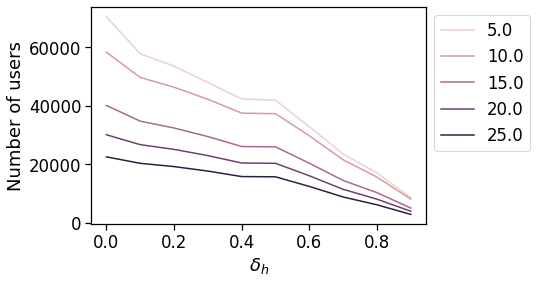

In [28]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
sns.lineplot(x='delta_duration', y='n_users',
             data=df_cnt_hw_locs.query('n_days == 2'),
             hue='n_hours'
            )
plt.legend(loc=2, bbox_to_anchor=[1,1])
plt.xlabel(r"$\delta_h$")
plt.ylabel("Number of users")

### Convert the home work locations from long to wide format

In [23]:
path_df_hw_locs_pd = os.path.join(OUT_DIR, 'df_hw_locs_pd.pkl')
if recomputeAll and os.path.exists(path_df_hw_locs_pd):
    os.remove(path_df_hw_locs_pd)
    
if not os.path.exists(path_df_hw_locs_pd):
    df_hw_locs_pd = mk.stats.compressLocsStats2hwTable(user_locs_stats_hw_separated)
    pd.to_pickle(df_hw_locs_pd, path_df_hw_locs_pd)
    
df_hw_locs_pd = pd.read_pickle(path_df_hw_locs_pd)
df_hw_locs_pd.head(0)

Empty DataFrame
Columns: [tot_pings, home_loc_ID, lat_home, lng_home, home_pings, work_loc_ID, lat_work, lng_work, work_pings]
Index: []

### Limit the analysis to users with sufficient home/work stats

In [30]:
min_pings_home_work = 5

In [31]:
print("We start with", df_hw_locs_pd.shape[0], "users...")
clean_df_hw_locs_pd = df_hw_locs_pd.query('home_pings >= @min_pings_home_work & work_pings >= @min_pings_home_work').copy(deep=True)
good_users_hw = clean_df_hw_locs_pd.index
print("... and we end with", clean_df_hw_locs_pd.shape[0], "users.")

We start with 187710 users...
... and we end with 91790 users.


## Spatial and travel indicators

Now we start computing some indicators both for each area and for the single users:
- for the area-based stats, in order to lower noise we will buffer the users home location of `homeWorkBufferMeters` meters and assign the user stat to
  all the cell grids touched by the buffer.  Then we compute the min,max,mean,std,count stats for all the users assigned to an area.
- for the user-based stats, we keep growing a `user_stats_table_df` which initially is a merge of the total per-user pings/days tables and his home/work stats.
  Then we will later add the stats on home/work travel time, radius of gyration etc.

### Spatial distribution of users
Later we will compute the zonal statistics of urban spatial structure by looking at the typical travel/commuting features of the users residing in a given area.
To this end, we compute once for all:
- the users found residing in each area.
- the distance of each user's home from the CBD closest to its workplace location. This allows us to check the functioning of the selected indicators on the distance from BD canceling out the policentric nature of a city.
  To do so, we pass the `multiple_cbd_latlon` array to the `mk.spatial.user_dist_cbds` that computes the distance of the user's workplace w.r.t. each and every BD of the policentric city. Then, the function saves in the `closest_cbd_dist` column the user's home euclidean distance from the reference BD.

In [32]:
users_buffered_per_area = mk.stats.computeBufferStat(
                                gdf_stat=clean_df_hw_locs_pd.reset_index()[['lat_home','lng_home', uidColName]],
                                gdf_grid=gdf_aoi_grid,
                                column=uidColName,
                                aggregation=set,
                                lat_name='lat_home',
                                lon_name='lng_home',
                                local_EPSG=local_EPSG,
                                buffer=500)

# Normalize the number of users found to live in each area
users_buffered_per_area['nUsers'] = users_buffered_per_area[uidColName].apply(len)
users_buffered_per_area['nUsers'] /= users_buffered_per_area['nUsers'].sum()

/home/enrico/.local/share/virtualenvs/jupyter-EWzvnNR1/lib/python3.8/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


In [33]:
# I also compute the distance from the different BDs of each valide user's home.
clean_df_hw_locs_pd = mk.spatial.user_dist_cbds(clean_df_hw_locs_pd, multiple_cbd_latlon)
clean_df_hw_locs_pd.head(0)

Empty DataFrame
Columns: [tot_pings, home_loc_ID, lat_home, lng_home, home_pings, work_loc_ID, lat_work, lng_work, work_pings, closest_cbd_idx, closest_cbd_dist]
Index: []

In [34]:
user_stats_table_df = clean_df_hw_locs_pd.join(
                                            users_stats_df.set_index(uidColName),
                                            how='inner')
user_stats_table_df.head(0)

Empty DataFrame
Columns: [tot_pings, home_loc_ID, lat_home, lng_home, home_pings, work_loc_ID, lat_work, lng_work, work_pings, closest_cbd_idx, closest_cbd_dist, min_day, max_day, pings, daysActive, daysSpanned, pingsPerDay, avg]
Index: []

### Daily total traveled distance

We compute the per-user-day total travel distance.

Here we use the pings as they contain all the trajectories of the users, so we do not limit the user's trips to the as crows fly distance between their stops locations but we include the actual path.

We also compute the daily ROG computed on the positions of the user for a particular day.

In [35]:
path_TTD_user_day = os.path.join(OUT_DIR, 'TTD_user_day.pkl')
if recomputeAll and os.path.exists(path_TTD_user_day):
    os.remove(path_TTD_user_day)
if not os.path.exists(path_TTD_user_day):
    result_ttd = mk.spatial.totalUserTravelDistance(df_pings_filtered,
                                                    doROG=True,
                                                    freq='1d').compute()
    pd.to_pickle(result_ttd, path_TTD_user_day)
result_ttd = pd.read_pickle(path_TTD_user_day)
result_ttd.head(0)

Empty DataFrame
Columns: [ttd, rog, nPings]
Index: []

In [36]:
# Merge the average daily rog and ttd keeping the days with a minimum of pings
user_stats_table_df = user_stats_table_df.join(
    result_ttd.query('nPings>5').groupby(level=0)[['ttd','rog']].agg('mean'),
    how='left',
)
user_stats_table_df.head(0)

Empty DataFrame
Columns: [tot_pings, home_loc_ID, lat_home, lng_home, home_pings, work_loc_ID, lat_work, lng_work, work_pings, closest_cbd_idx, closest_cbd_dist, min_day, max_day, pings, daysActive, daysSpanned, pingsPerDay, avg, ttd, rog]
Index: []

In [37]:
perAreaDailyTTD = mk.stats.userBasedBufferedStat(result_ttd, users_buffered_per_area,
                                        stat_col='ttd')

In [38]:
perAreaDailyROG = mk.stats.userBasedBufferedStat(result_ttd, users_buffered_per_area,
                                        stat_col='rog')

In [39]:
perAreaDailyTTD.head(0)

Empty DataFrame
Columns: [ttd_min, ttd_max, ttd_mean, ttd_std, ttd_count]
Index: []

### Radius of Gyration

We compute the per-user ROG w.r.t. his home and his mean position for the whole duration of the data.

In this case this will be a monthly ROG for the users. Below we will show how to compute the daily ROG.

In [40]:
rogs_user_pd = mk.spatial.compute_ROG(
                                exploded_stops_df,
                                which='both',
                                df_hw_locs=df_hw_locs_pd)

In [41]:
path_users_rog = os.path.join(OUT_DIR, 'user_rog.pkl')
if recomputeAll and os.path.exists(path_users_rog):
    os.remove(path_users_rog)
if not os.path.exists(path_users_rog):
    rogs_user_pd = rogs_user_pd.compute()
    rogs_user_pd.to_pickle(path_users_rog)
rogs_user_pd = pd.read_pickle(path_users_rog)
rogs_user_pd.head(0)

Empty DataFrame
Columns: [n_pings, rog_home, com_home_lat, com_home_lng, rog_total, com_total_lat, com_total_lng]
Index: []

In [42]:
# Merge the average rog w.r.t. home and c.o.m.
user_stats_table_df = user_stats_table_df.join(rogs_user_pd.query('n_pings > 5'),
                                               how='left')
user_stats_table_df.head(0)

Empty DataFrame
Columns: [tot_pings, home_loc_ID, lat_home, lng_home, home_pings, work_loc_ID, lat_work, lng_work, work_pings, closest_cbd_idx, closest_cbd_dist, min_day, max_day, pings, daysActive, daysSpanned, pingsPerDay, avg, ttd, rog, n_pings, rog_home, com_home_lat, com_home_lng, rog_total, com_total_lat, com_total_lng]
Index: []

[0 rows x 27 columns]

Text(0, 0.5, '$P(r)$')

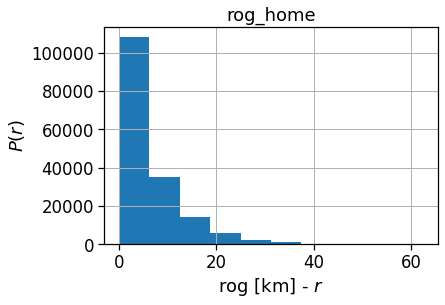

In [43]:
rogs_user_pd[['rog_home']].hist()
plt.xlabel(r'rog [km] - $r$')
plt.ylabel(r'$P(r)$')

<AxesSubplot:xlabel='rog_total', ylabel='rog_home'>

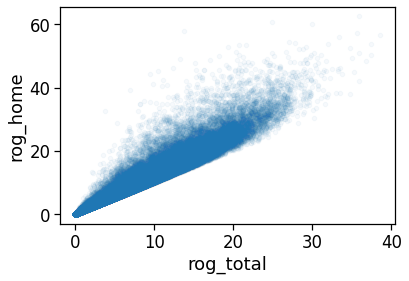

In [44]:
rogs_user_pd.plot('rog_total', 'rog_home',
                  alpha=.04, kind='scatter')

### Number of houses/offices

We:
- project the user home/work locations to the local projection given by `local_EPSG`;
- buffer their location by `homeWorkBufferMeters` meters to simulate a kernel density (with flat kernel over a circle);
- count the number of offices and homes found in each cell and compute their absolute ratio;

**NOTE**
>When determining the home location of a user, please consider that some data providers, like Cuebiq, obfuscate/obscure/alter the coordinates of the points falling near the user’s home location in order to preserve privacy.
>
>This means that you cannot locate the precise home of a user with a spatial resolution higher than the one used to obfuscate these data. If you are interested in the census area (or geohash) of the user’s home alone and you are using a spatial tessellation with a spatial resolution wider than or equal to the one used to obfuscate the data, then this is of no concern.
>
>However, tasks such as stop-detection or POI visit rate computation may be affected by the noise added to data in the user’s home location area. Please check if your data has such noise added and choose the spatial tessellation according to your use case.

In [45]:
home_counts = mk.stats.computeBufferStat(
                                gdf_stat=clean_df_hw_locs_pd.reset_index()
                                                [['lat_home','lng_home', uidColName]],
                                gdf_grid=gdf_aoi_grid,
                                column=uidColName,
                                aggregation='nunique',
                                lat_name='lat_home',
                                lon_name='lng_home',
                                local_EPSG=local_EPSG,
                                buffer=500)
home_counts = home_counts.rename(columns={uidColName: 'n_homes'})['n_homes'].to_dict()

/home/enrico/.local/share/virtualenvs/jupyter-EWzvnNR1/lib/python3.8/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


In [46]:
work_counts = mk.stats.computeBufferStat(
                                gdf_stat=clean_df_hw_locs_pd.reset_index()
                                                [['lat_work','lng_work', uidColName]],
                                gdf_grid=gdf_aoi_grid,
                                column=uidColName,
                                aggregation='nunique',
                                lat_name='lat_work',
                                lon_name='lng_work',
                                local_EPSG=local_EPSG,
                                buffer=500)
work_counts = work_counts.rename(columns={uidColName: 'n_works'})['n_works'].to_dict()

/home/enrico/.local/share/virtualenvs/jupyter-EWzvnNR1/lib/python3.8/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


### Length and duration of commute

We want to compute the time of commuting starting from the original stops (the ones with the leaving datetime).

For each user we compute:
- the straight line distance between home and work location;
- the distance based on the actual time from departing home arriving in work cell and viceversa;
- the "traffic-free" solution based on a osrm backend telling the travel time by car on the OSM street graph.

In order to have a running osrm-backend server you can use `docker` (see [here](https://github.com/Project-OSRM/osrm-backend) for details):

```
wget http://download.geofabrik.de/europe/germany/berlin-latest.osm.pbf
osrm-extract -p your_profile berlin.osm.pbf
osrm-partition berlin.osrm
osrm-customize berlin.osrm
sudo docker run -t -i -p 5000:5000 -v "${PWD}:/data" osrm/osrm-backend osrm-routed --algorithm=MLD /data/berlin-latest.osrm
```

In [47]:
df_hw_locs_pd.head(0)

Empty DataFrame
Columns: [tot_pings, home_loc_ID, lat_home, lng_home, home_pings, work_loc_ID, lat_work, lng_work, work_pings]
Index: []

In [48]:
path_df_user_home_work_distance_time = os.path.join(OUT_DIR, 'users_home_work_times_distance.pkl')
if recomputeAll and os.path.exists(path_df_user_home_work_distance_time):
    os.remove(path_df_user_home_work_distance_time)
if not os.path.exists(path_df_user_home_work_distance_time):
    
    clean_df_hw_locs_pd = mk.stats.computeUserHomeWorkTripTimes(clean_df_hw_locs_pd,
                                                      osrm_url=osrm_url,
                                                      direction='both',
                                                      what='duration,distance',
                                                     )
    pd.to_pickle(clean_df_hw_locs_pd, path_df_user_home_work_distance_time)
clean_df_hw_locs_pd = pd.read_pickle(path_df_user_home_work_distance_time)

In [49]:
clean_df_hw_locs_pd.head(0)

Empty DataFrame
Columns: [tot_pings, home_loc_ID, lat_home, lng_home, home_pings, work_loc_ID, lat_work, lng_work, work_pings, closest_cbd_idx, closest_cbd_dist, home_work_straight_dist, home_work_osrm_time, home_work_osrm_dist, work_home_osrm_time, work_home_osrm_dist]
Index: []

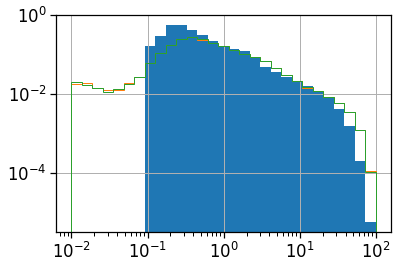

In [50]:
clean_df_hw_locs_pd['home_work_straight_dist'].hist(bins=np.logspace(-2,2,30), density=True)
(clean_df_hw_locs_pd['home_work_osrm_dist']/1000).hist(bins=np.logspace(-2,2,30), density=True,
                                          histtype='step', color='C1')
(clean_df_hw_locs_pd['work_home_osrm_dist']/1000).hist(bins=np.logspace(-2,2,30), density=True,
                                          histtype='step', color='C2')
plt.loglog();

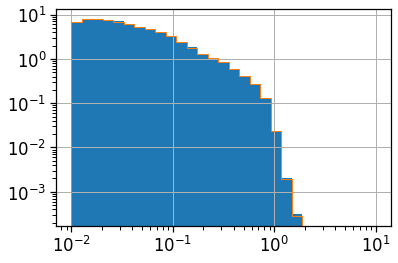

In [51]:
(clean_df_hw_locs_pd['home_work_osrm_time']/3600).hist(bins=np.logspace(-2,1,30), density=True)
(clean_df_hw_locs_pd['work_home_osrm_time']/3600).hist(bins=np.logspace(-2,1,30), density=True,
                                          histtype='step', color='C1')
plt.loglog();

### Real commuting duration
These are instead the real time from home to work (or the other way around).

These are computed by looking at the time-ordered sequence of the stops of the user, looking at all the time when the user was at home and then at work within a given time window.

In [52]:
user_time_trips_hw = mk.stats.userRealHomeWorkTimes(df_stops=users_stop_locs_df,
                                                    home_work_locs=clean_df_hw_locs_pd,
                                                    direction='both',
                                                    location_col=locColName)
user_time_trips_hw

Dask DataFrame Structure:
                time_trips_hw speed_trips_hw time_trips_wh speed_trips_wh home_work_straight_dist home_work_osrm_time work_home_osrm_time home_work_osrm_dist work_home_osrm_dist
npartitions=200                                                                                                                                                                  
                       object         object        object         object                 float64             float64             float64             float64             float64
                          ...            ...           ...            ...                     ...                 ...                 ...                 ...                 ...
...                       ...            ...           ...            ...                     ...                 ...                 ...                 ...                 ...
                          ...            ...           ...            ...                     ...                 ...                 ...                 ...                 ...
                          ...            ...           ...            ...                     ...                 ...                 ...                 ...                 ...
Dask Name: per_user_real_home_work_times, 16676 tasks

In [53]:
path_df_user_timetrips_hw = os.path.join(OUT_DIR, 'users_time_trips_home_work.pkl')
if recomputeAll and os.path.exists(path_df_user_timetrips_hw):
    os.remove(path_df_user_timetrips_hw)
if not os.path.exists(path_df_user_timetrips_hw):
    
    user_time_trips_hw = user_time_trips_hw.compute()
    
    pd.to_pickle(user_time_trips_hw, path_df_user_timetrips_hw)
user_time_trips_hw = pd.read_pickle(path_df_user_timetrips_hw)

In [54]:
user_time_trips_hw.head(0)

Empty DataFrame
Columns: [time_trips_hw, speed_trips_hw, time_trips_wh, speed_trips_wh, home_work_straight_dist, home_work_osrm_time, work_home_osrm_time, home_work_osrm_dist, work_home_osrm_dist]
Index: []

In [55]:
user_stats_table_df.head(0)

Empty DataFrame
Columns: [tot_pings, home_loc_ID, lat_home, lng_home, home_pings, work_loc_ID, lat_work, lng_work, work_pings, closest_cbd_idx, closest_cbd_dist, min_day, max_day, pings, daysActive, daysSpanned, pingsPerDay, avg, ttd, rog, n_pings, rog_home, com_home_lat, com_home_lng, rog_total, com_total_lat, com_total_lng]
Index: []

[0 rows x 27 columns]

In [56]:
# Merge the new columns computed time
user_stats_table_df = user_stats_table_df.join(user_time_trips_hw, how='left')
for c in ['time_trips_hw', 'speed_trips_hw', 'time_trips_wh', 'speed_trips_wh']:
    if c in user_stats_table_df.columns:
        user_stats_table_df[c] = user_stats_table_df[c].apply(lambda l: None if l is None or len(l)==0 else np.mean(l))
user_stats_table_df.head(0)

Empty DataFrame
Columns: [tot_pings, home_loc_ID, lat_home, lng_home, home_pings, work_loc_ID, lat_work, lng_work, work_pings, closest_cbd_idx, closest_cbd_dist, min_day, max_day, pings, daysActive, daysSpanned, pingsPerDay, avg, ttd, rog, n_pings, rog_home, com_home_lat, com_home_lng, rog_total, com_total_lat, com_total_lng, time_trips_hw, speed_trips_hw, time_trips_wh, speed_trips_wh, home_work_straight_dist, home_work_osrm_time, work_home_osrm_time, home_work_osrm_dist, work_home_osrm_dist]
Index: []

[0 rows x 36 columns]

In [57]:
path_df_timetrip_stats = os.path.join(OUT_DIR, 'time_trips_stats_home_work.pkl')
if recomputeAll and os.path.exists(path_df_timetrip_stats):
    os.remove(path_df_timetrip_stats)
if not os.path.exists(path_df_timetrip_stats):
    
    time_trips_stats_df = mk.stats.computeTripTimeStats(df_trip_times=user_time_trips_hw,
                                           df_hw_locs=clean_df_hw_locs_pd,
                                           gdf_grid=gdf_aoi_grid,
                                           local_EPSG=local_EPSG,
                                           buffer_m=500)
    
    pd.to_pickle(time_trips_stats_df, path_df_timetrip_stats)
time_trips_stats_df = pd.read_pickle(path_df_timetrip_stats)

In [58]:
time_trips_stats_df.head(0)

Empty GeoDataFrame
Columns: [uid, time_trips_hw_min, time_trips_hw_max, time_trips_hw_avg, time_trips_hw_std, time_trips_wh_min, time_trips_wh_max, time_trips_wh_avg, time_trips_wh_std, speed_trips_hw_min, speed_trips_hw_max, speed_trips_hw_avg, speed_trips_hw_std, speed_trips_wh_min, speed_trips_wh_max, speed_trips_wh_avg, speed_trips_wh_std, home_work_straight_dist_min, home_work_straight_dist_max, home_work_straight_dist_avg, home_work_straight_dist_std, home_work_osrm_time_min, home_work_osrm_time_max, home_work_osrm_time_avg, home_work_osrm_time_std, work_home_osrm_time_min, work_home_osrm_time_max, work_home_osrm_time_avg, work_home_osrm_time_std, home_work_osrm_dist_min, home_work_osrm_dist_max, home_work_osrm_dist_avg, home_work_osrm_dist_std, work_home_osrm_dist_min, work_home_osrm_dist_max, work_home_osrm_dist_avg, work_home_osrm_dist_std]
Index: []

[0 rows x 37 columns]

In [59]:
# Compute the average time fraction
time_trips_stats_df['avg_realT_frac_osmT'] = time_trips_stats_df.apply(lambda r: 
                                                    r['time_trips_hw_avg'] / max(0.1, r['home_work_osrm_time_avg']/3600.)
                                                        if not (
                                                            pd.isna(r['time_trips_hw_avg'])
                                                            or pd.isna(r['home_work_osrm_time_avg'])
                                                        ) else None, axis=1)
user_stats_table_df['avg_realT_frac_osmT'] = user_stats_table_df.apply(lambda r: 
                                                    r['time_trips_hw'] / max(0.1, r['home_work_osrm_time']/3600.)
                                                        if not (
                                                            pd.isna(r['time_trips_hw'])
                                                            or pd.isna(r['home_work_osrm_time'])
                                                        ) else None, axis=1)

In [60]:
# Compute the average distance fraction
time_trips_stats_df['avg_realD_frac_osmD'] = time_trips_stats_df.apply(lambda r: 
                                                    r['home_work_straight_dist_avg'] / max(0.1, r['home_work_osrm_dist_avg']/1000.)
                                                        if not (
                                                            pd.isna(r['home_work_straight_dist_avg'])
                                                            or pd.isna(r['home_work_osrm_dist_avg'])
                                                        ) else None, axis=1)
user_stats_table_df['avg_realD_frac_osmD'] = user_stats_table_df.apply(lambda r: 
                                                    r['home_work_straight_dist'] / max(0.1, r['home_work_osrm_dist']/1000.)
                                                        if not (
                                                            pd.isna(r['home_work_straight_dist'])
                                                            or pd.isna(r['home_work_osrm_dist'])
                                                        ) else None, axis=1)

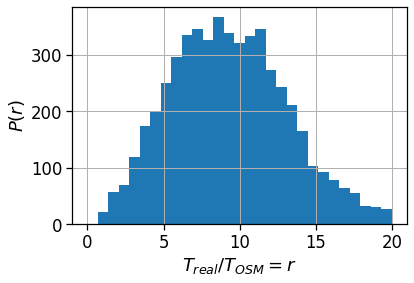

In [61]:
time_trips_stats_df['avg_realT_frac_osmT'].hist(bins=np.linspace(0,20,30))
plt.xlabel(r'$T_{real} / T_{OSM} = r$')
plt.ylabel(r'$P(r)$')
plt.savefig(os.path.join(OUT_DIR_FIG, 'avg_realT_frac_osmT_hist.pdf'))

Also the distribution of the ratio between the as-crows-fly and the "theoretical one" shows that only few people have access to a nearly straight home-work commuting route.

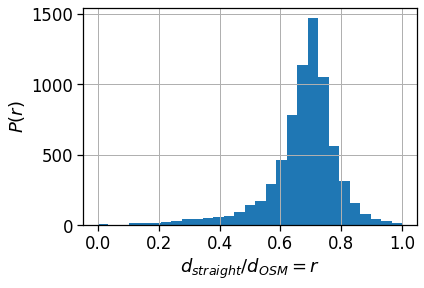

In [62]:
time_trips_stats_df['avg_realD_frac_osmD'].hist(bins=np.linspace(0,1.,30))
plt.xlabel(r'$d_{straight} / d_{OSM} = r$')
plt.ylabel(r'$P(r)$')
plt.savefig(os.path.join(OUT_DIR_FIG, 'avg_realD_frac_osmD_hist.pdf'))

## Urban spatial structure

In this section we investigate the spatial structure of the city.
In particular, we inspect the spatial functioning of some relevant observables and study the their spatial dependence on their distance to the Central Business District (CBD) or to the user's reference Business District (BD, see below for definition).

We will compute:
- the daily user's Radius Of Gyration (ROG) and Total Traveled Distance (TTD);
- the ratio between the number of homes and office locations found in each cell grid;
- the mean home-work commuting length and duration per user and per cell, also with respect to the traffic-free scenario computed with OSRM.

However, we start with another perspective, the land use detection.

### Compute areas profiles

To compute the land use of single areas we refer to the work of [Toole et al.](https://doi.org/10.1145/2346496.2346498)
> Toole, J. L., Ulm, M., González, M. C. & Bauer, D. Inferring land use from mobile phone activity.
> in Proceedings of the ACM SIGKDD International Workshop on Urban Computing - UrbComp 12 (ACM Press, 2012).

i.e., we start computing the activity of the grid cells (i.e., the number of people observed in a given cell at each hour of the day in specific days) and we later normalize this volume to cancel out the fluctuactions in the number of users/pings registered in the data.

In this case we want to detect the weekdays landuse of an area, by looking at:
- weekdays only (Monday to Friday);
- keep under consideration areas with sufficient statistics only.

We compute the hourly occupation rate $a(c,h,d) = N_u(c,h,d) / N^{TOT}_u(d)$ of a cell $c$ with respect to the total volume of users observed on that day $N^{TOT}_u(d)$.


In [63]:
profile_period = "day"
profile_timeBin = "H"
signal_column = "frac_users"
weekdays = [0,1,2,3,4]
min_area_covered_hours = 72
min_area_observed_pings = 500

### Rename the columns
We are interested in the time bin when the stop is present, so we overwrite the `datetime` column name with the `stops` one (the latter contains the info about the repetition of the stop.)

In [64]:
exploded_stops_df[dttColName] = exploded_stops_df['stops']

### Compute the profiles

For each day we compute the hourly profile of the single grid cell.

In [65]:
total_profiles_df = mk.temporal.computeTemporalProfile(exploded_stops_df,
                                                             timeBin=profile_timeBin,
                                                             weekdays=weekdays,
                                                             byArea=True,
                                                             profile=profile_period,
                                                             normalization="total")
total_profiles_df

/home/enrico/.local/share/virtualenvs/jupyter-EWzvnNR1/lib/python3.8/site-packages/dask/dataframe/core.py:3935: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('users', 'int64'))

  warnings.warn(meta_warning(meta))


Dask DataFrame Structure:
                           day tile_ID               H  users  pings tot_users tot_pings frac_users frac_pings pings_per_user profile_hour
npartitions=10                                                                                                                            
                datetime64[ns]   int64  datetime64[ns]  int64  int64     int64     int64    float64    float64        float64        int64
                           ...     ...             ...    ...    ...       ...       ...        ...        ...            ...          ...
...                        ...     ...             ...    ...    ...       ...       ...        ...        ...            ...          ...
                           ...     ...             ...    ...    ...       ...       ...        ...        ...            ...          ...
                           ...     ...             ...    ...    ...       ...       ...        ...        ...            ...          ...
Dask Name: assign, 15765 tasks

In [66]:
path_total_profiles = os.path.join(OUT_DIR, 'total_profiles.pkl')
if recomputeAll and os.path.exists(path_total_profiles):
    os.remove(path_total_profiles)
if not os.path.exists(path_total_profiles):
    total_profiles_df = total_profiles_df.compute()
    total_profiles_df.to_pickle(path_total_profiles)
total_profiles_df = pd.read_pickle(path_total_profiles)

In [67]:
total_profiles_df.head(0)

Empty DataFrame
Columns: [day, tile_ID, H, users, pings, tot_users, tot_pings, frac_users, frac_pings, pings_per_user, profile_hour]
Index: []

[]

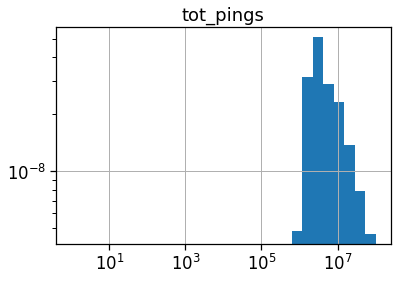

In [68]:
# Visualize the number of pings per area
total_profiles_df.groupby('tile_ID').agg({'tot_pings': sum}).hist(bins=np.logspace(0, 8, 30), density=True)
plt.loglog()

In [69]:
# We select the good areas to be the one with sufficient hours covered
# and with at least some stops observed
good_areas = set(total_profiles_df.groupby('tile_ID')
                                     .agg({'tot_pings': sum, 'H': 'nunique'})
                                        .query('H > @min_area_covered_hours & tot_pings > @min_area_observed_pings').index)
len(good_areas)

4998

In [70]:
# Then I clean the profiles to keep only valid areas and compute the residual activities... 
cleaned_profiles = total_profiles_df.query('tile_ID in @good_areas').copy(deep=True)
residual_activities, mappings =  mk.temporal.computeResiduals(cleaned_profiles,
                                                        signal_column=signal_column,
                                                        profile=profile_period)

### Infer land use

We now cluster the per-areas profiles of users presence fraction using a hierarchical clustering with a Ward linking and a cosine distance.

We inspect the Calinski-Harabaz score to find a local maximum to select the number of clusters that bast partition the data.

In this case we use 6 clusters.

Done n clusters = 02
Done n clusters = 03
Done n clusters = 04
Done n clusters = 05
Done n clusters = 06
Done n clusters = 07
Done n clusters = 08
Done n clusters = 09
Done n clusters = 10


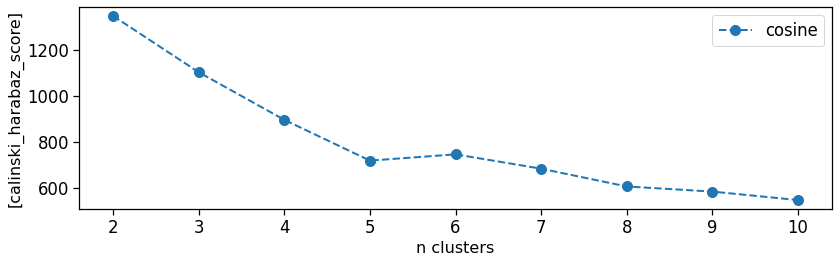

In [71]:
signal_to_use = "residual"
metric = "cosine"  # The metric to be used in computing the distance matrix

results_clusters = mk.tools.computeClusters(residual_activities,
                                                  signal_to_use,
                                                  metric=metric,
                                                  nClusters=range(2,11))

# Visualize score
ax_score = mk.tools.checkScore(results_clusters)
plt.savefig(os.path.join(OUT_DIR_FIG, 'landuse_score.pdf'))

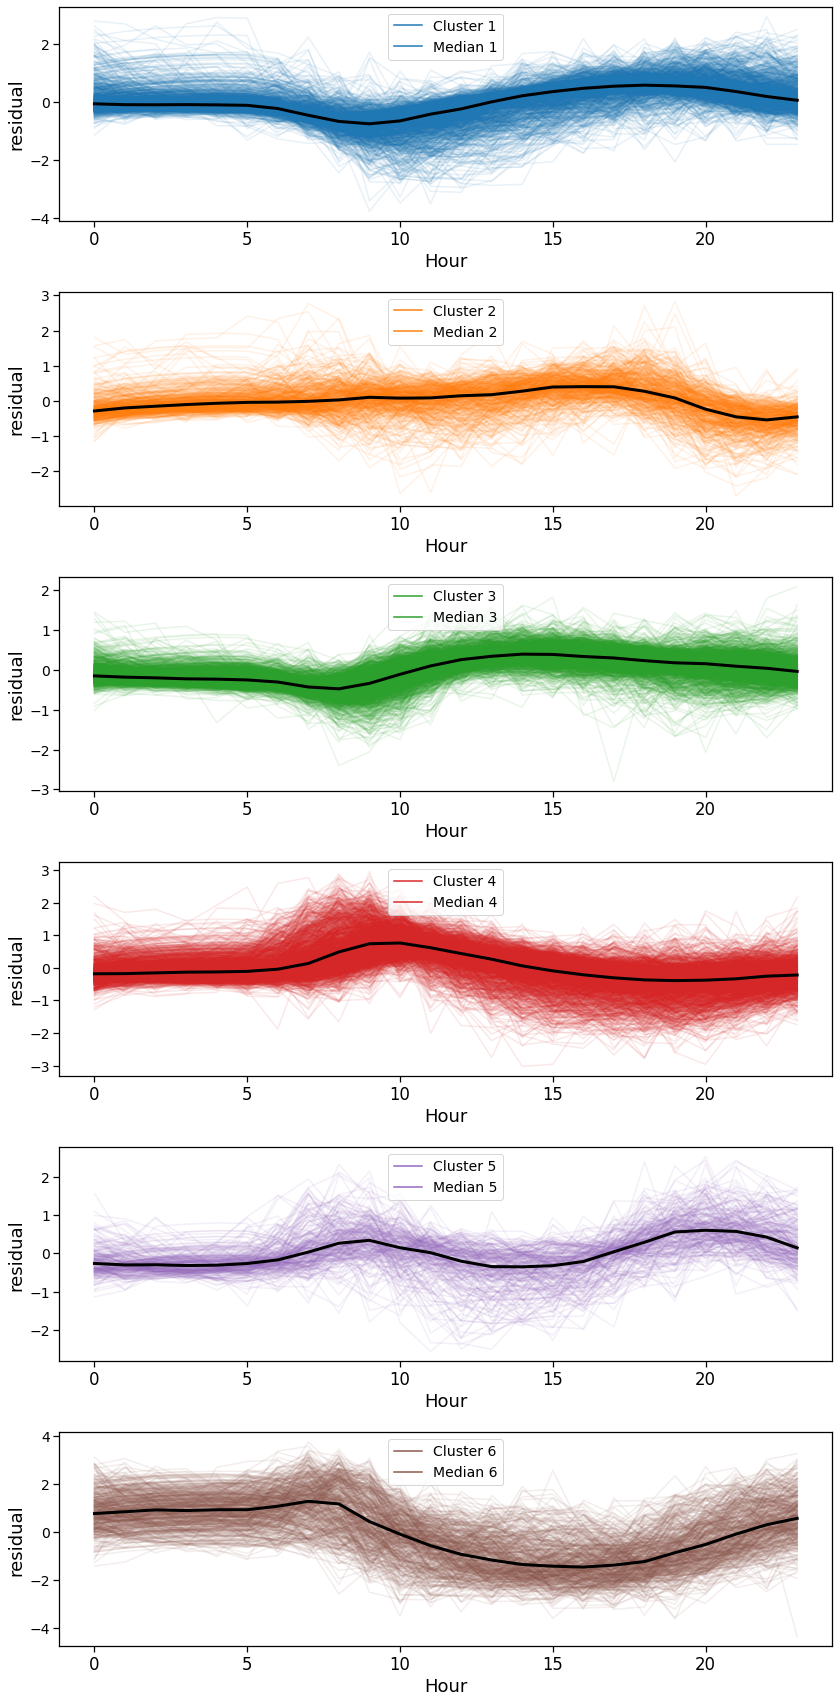

In [72]:
nClusters = 6
ax = mk.tools.visualizeClustersProfiles(results_clusters,
                                        nClusts=nClusters,
                                        showMean=False,
                                        showMedian=True,
                                        showCurves=True)
plt.savefig(os.path.join(OUT_DIR_FIG, 'landuse_curves_all.pdf'))

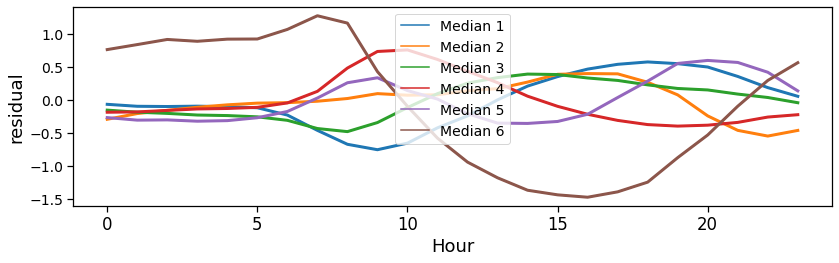

In [73]:
ax = mk.tools.visualizeClustersProfiles(results_clusters,
                                        nClusts=nClusters,
                                        showMean=False,
                                        showMedian=True,
                                        showCurves=False,
                                        together=True,
                                       )
plt.savefig(os.path.join(OUT_DIR_FIG, 'landuse_curves_median.pdf'))

Given the residual activities found, we categorize the landuse by looking at when an area is more active than the overall average. A peak during night-time indicates a residential area, whereas a peak during office hours is an hint for a commercial/workplace oriented area.

In [74]:
rename_clusters = {
    1: 'Workplace/Leisure',
    2: 'Commercial/Workplace',
    3: 'Workplace',
    4: 'Schools/Commuting',
    5: 'Commuting/Leisure',
    6: 'Residential',
    7: '',
    -1: 'Unclassified',
}

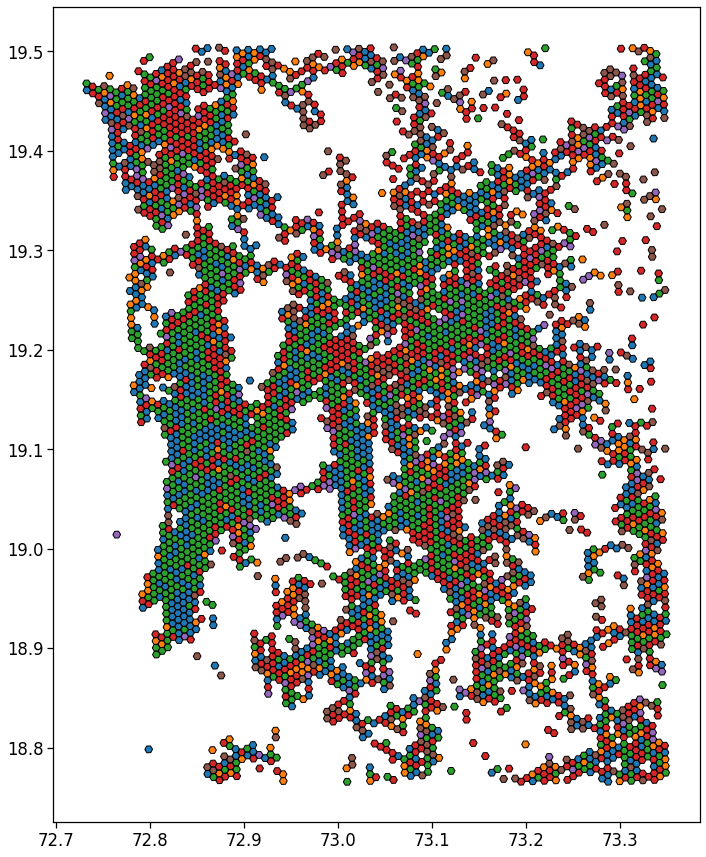

In [75]:
gdf_aoi_grid_landuse, ax = mk.tools.plotClustersMap(gdf_aoi_grid, results_clusters, mappings, nClusts=nClusters);
plt.savefig(os.path.join(OUT_DIR_FIG, 'landuse_map.pdf'))

In [76]:
gdf_aoi_grid_landuse['scope'] = gdf_aoi_grid_landuse['cluster'].replace(rename_clusters)

In [77]:
gdf_aoi_grid_landuse.to_file(out_grid_cells_file, driver='GPKG')

In [78]:
df_hw_locs_pd.head(0)

Empty DataFrame
Columns: [tot_pings, home_loc_ID, lat_home, lng_home, home_pings, work_loc_ID, lat_work, lng_work, work_pings]
Index: []

## Map the indicators

In the following, we start mapping the computed indicators and check their functioning with distance from CBD. 

### Users density

We plot the mapping of where most of the home location are found.

We show the density by dividing the number of houses per area by their total count.

From here on, we will simply join the indicators computed in the previous section with the GeoDataFrame containing the areas to visualize the spatial mapping of the observables.

In [79]:
gdf_aoi_grid_landuse = pd.merge(gdf_aoi_grid_landuse,
                                 users_buffered_per_area[['nUsers']].reset_index(),
                                 on=zidColName,
                                 how='left')

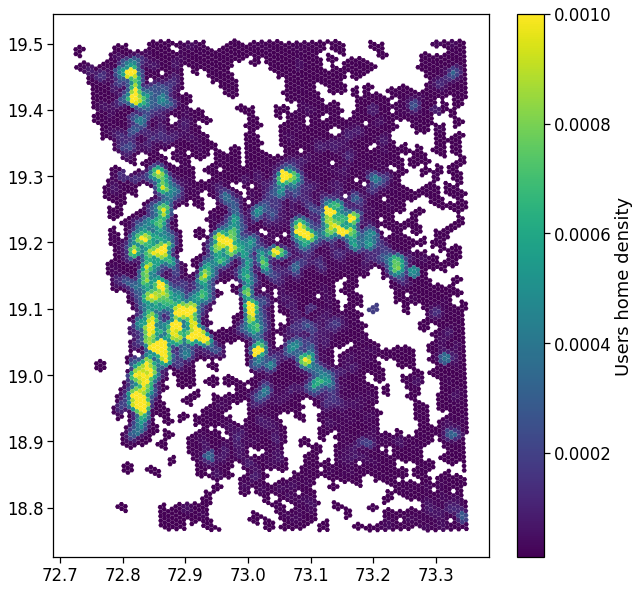

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
gdf_aoi_grid_landuse.plot('nUsers', vmin=1e-5, vmax=1e-3,
                          legend=True, ax=ax,
                          legend_kwds={'label': r'Users home density'})
plt.savefig(os.path.join(OUT_DIR_FIG, 'user_home_density_map.pdf'))

### Radius of Gyration
We compute the ROG w.r.t. home and day/week medoid/mean position.

We also compute the average radius of gyration per grid cell mapping all the users with the home in that cell.

We simply merge the radius of gyration table with the user's home location and aggregate over the `tile_ID`.

We also normalize the user count to hide the dataset statistics.

In [81]:
cleaned_users_rog = rogs_user_pd.query('n_pings > 10').copy(deep=True)
cleaned_user_stats_table_df = user_stats_table_df.join(cleaned_users_rog[[]], how='inner')
cleaned_user_stats_table_df = cleaned_user_stats_table_df.query('home_work_straight_dist > .75')
print('Selected', cleaned_users_rog.shape[0], 'out of', rogs_user_pd.shape[0], 'users for rog.')
print('Selected', cleaned_user_stats_table_df.shape[0], 'out of', user_stats_table_df.shape[0], 'users for stats.')

Selected 160891 out of 187710 users for rog.
Selected 69890 out of 91790 users for stats.


In [82]:
perAreaTotalROG = mk.stats.userBasedBufferedStat(cleaned_users_rog,
                                            users_buffered_per_area,
                                            stat_col='rog_total')

perAreaHomeROG = mk.stats.userBasedBufferedStat(cleaned_users_rog,
                                            users_buffered_per_area,
                                            stat_col='rog_home')

In [83]:
perAreaTotalROG.head(0)

Empty DataFrame
Columns: [rog_total_min, rog_total_max, rog_total_mean, rog_total_std, rog_total_count]
Index: []

In [84]:
for c in list(perAreaTotalROG.columns) + list(perAreaHomeROG.columns):
    if c in gdf_aoi_grid_landuse:
        del gdf_aoi_grid_landuse[c]
        
gdf_aoi_grid_landuse = pd.merge(gdf_aoi_grid_landuse,
                                 perAreaTotalROG.reset_index(),
                                 on=zidColName,
                                 how='left')

gdf_aoi_grid_landuse = pd.merge(gdf_aoi_grid_landuse,
                                 perAreaHomeROG.reset_index(),
                                 on=zidColName,
                                 how='left')

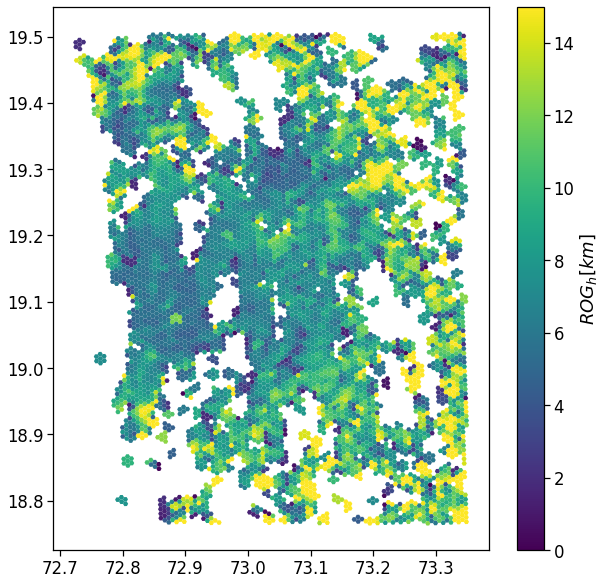

In [85]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
gdf_aoi_grid_landuse.plot('rog_home_mean', vmin=.0, vmax=15.,
                          legend=True, ax=ax,
                          legend_kwds={'label': r'$ROG_{h} [km]$'})
plt.savefig(os.path.join(OUT_DIR_FIG, 'user_rog_home_map.pdf'))

In [86]:
# Save the result
gdf_aoi_grid_landuse.to_file(out_grid_cells_file, driver='GPKG')

### Compute the distance w.r.t. the city center

To inspect the functioning of each observables w.r.t. the CBD, we compute the distance of each grid cell with respect to the city center in the `cbd_dist` column.

Also, to smooth the plotting, we divide the distances in bins of 2.5 km to group the observables and reduce the noise.

In [87]:
gdf_aoi_grid_landuse['cbd_dist'] = haversine_pairwise(
    np.hstack((
        gdf_aoi_grid_landuse.geometry.centroid.y.values.reshape(-1,1),
        gdf_aoi_grid_landuse.geometry.centroid.x.values.reshape(-1,1))
    ),
    center_of_city,
)

cleaned_user_stats_table_df['cbd_dist'] = haversine_pairwise(
    np.hstack((
        cleaned_user_stats_table_df['lat_home'].values.reshape(-1,1),
        cleaned_user_stats_table_df['lng_home'].values.reshape(-1,1)
    )),
    center_of_city,
)

user_stats_table_df['cbd_dist'] = haversine_pairwise(
    np.hstack((
        user_stats_table_df['lat_home'].values.reshape(-1,1),
        user_stats_table_df['lng_home'].values.reshape(-1,1)
    )),
    center_of_city,
)

dist_bin = 2.5
gdf_aoi_grid_landuse['cbd_dist_bin'] = np.floor(gdf_aoi_grid_landuse['cbd_dist'] / dist_bin)*dist_bin
cleaned_user_stats_table_df['cbd_dist_bin']  = np.floor(cleaned_user_stats_table_df['cbd_dist'] / dist_bin)*dist_bin
cleaned_user_stats_table_df['closest_cbd_dist_bin']  = np.floor(cleaned_user_stats_table_df['closest_cbd_dist'] / dist_bin)*dist_bin
user_stats_table_df['closest_cbd_dist_bin']  = np.floor(user_stats_table_df['closest_cbd_dist'] / dist_bin)*dist_bin

/tmp/ipykernel_1452718/688516821.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_aoi_grid_landuse.geometry.centroid.y.values.reshape(-1,1),
/tmp/ipykernel_1452718/688516821.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_aoi_grid_landuse.geometry.centroid.x.values.reshape(-1,1))


We also check the correlation between the ROG and the distance from the CBD.

In [88]:
# Linear interpolation of rog vs distance...
tmp_data = gdf_aoi_grid_landuse[[
    'rog_home_mean',
    'cbd_dist'
]].dropna()

model = sm.GLS(tmp_data['rog_home_mean'],
               tmp_data['cbd_dist'])
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 GLS Regression Results                                
=======================================================================================
Dep. Variable:          rog_home_mean   R-squared (uncentered):                   0.728
Model:                            GLS   Adj. R-squared (uncentered):              0.728
Method:                 Least Squares   F-statistic:                          1.951e+04
Date:                Mon, 16 May 2022   Prob (F-statistic):                        0.00
Time:                        15:52:26   Log-Likelihood:                         -22435.
No. Observations:                7289   AIC:                                  4.487e+04
Df Residuals:                    7288   BIC:                                  4.488e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cbd_dist       0.1912      0.001    139.669      0.000       0.189       0.194
==============================================================================
Omnibus:                     2651.633   Durbin-Watson:                   0.853
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22667.379
Skew:                           1.503   Prob(JB):                         0.00
Kurtosis:                      11.099   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

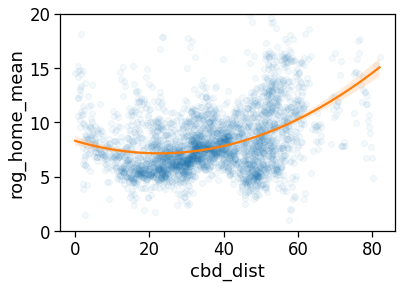

In [89]:
# The same analysis with a 2-degree interpolating line...
sns.regplot(
    x='cbd_dist',
    y='rog_home_mean',
    data=gdf_aoi_grid_landuse.query('rog_home_count>15'),
    line_kws={'color': 'C1'},
    scatter_kws={'alpha':.05},
    order=2,
)
plt.ylim(0,20)
plt.savefig(os.path.join(OUT_DIR_FIG, 'rogHome_vs_cbd_scatter.pdf'))

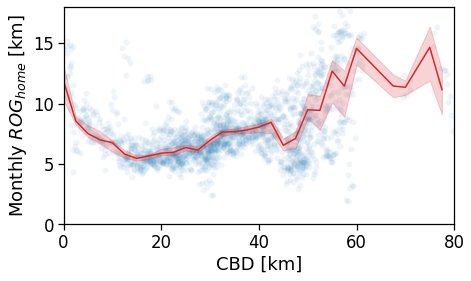

In [90]:
tmp_data = gdf_aoi_grid_landuse.query('rog_home_count > 50')\
                                .copy(deep=True)
fig, ax = compareLinePlot(
            data=tmp_data,
            x_scatter='cbd_dist',
            x_line='cbd_dist_bin',
            y='rog_home_mean',
            xlabel='CBD [km]',
            ylabel=r'Monthly $ROG_{home}$ [km]',
            xlim=[0,80],
            ylim=[0,18],
    )
plt.savefig(os.path.join(OUT_DIR_FIG, 'rogHome_vs_cbd_scatterLine.pdf'))

In [91]:
tmp_data = gdf_aoi_grid_landuse.query('rog_home_count > 50')\
                                .copy(deep=True)
fig, ax = compareLinePlot(
            data=tmp_data,
            x_scatter='cbd_dist',
            x_line='cbd_dist_bin',
            y='rog_total_mean',
            xlabel='CBD [km]',
            ylabel=r'Monthly $ROG_{total}$ [km]',
            xlim=[0,80],
            ylim=[0,18],
    )
plt.savefig(os.path.join(OUT_DIR_FIG, 'rogTotal_vs_cbd_scatterLine.pdf'))

Now we show the per-user plots: for each user we use his home's distance from the CBD (and later from the BD closest to his workplace).

We see that in a policentric city as Mumbai there is no clear dependence of the $ROG_{home}$ when we consider a single CBD.

In [92]:
tmp_data = cleaned_user_stats_table_df.copy(deep=True)

fig, ax = compareLinePlot(
            data=tmp_data,
            x_scatter='cbd_dist',
            x_line='cbd_dist_bin',
            y='rog_home',
            xlabel='CBD [km]',
            ylabel=r'Monthly $ROG_{home}$ [km]',
            xlim=[0,80],
            ylim=[0,60],
            scatterkws={'alpha': .0},
    )
plt.savefig(os.path.join(OUT_DIR_FIG, 'rogHome_vs_cbd_scatterLine_users_cbd.pdf'))

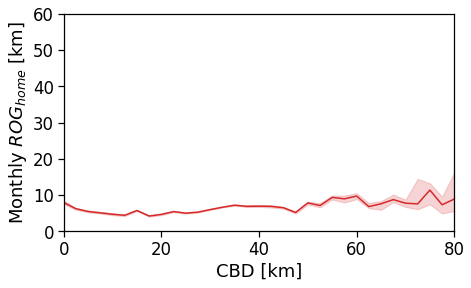

In [93]:
tmp_data = cleaned_user_stats_table_df.copy(deep=True)

fig, ax = compareLinePlot(
            data=tmp_data,
            x_scatter='cbd_dist',
            x_line='cbd_dist_bin',
            y='rog_total',
            xlabel='CBD [km]',
            ylabel=r'Monthly $ROG_{home}$ [km]',
            xlim=[0,80],
            ylim=[0,60],
            scatterkws={'alpha': .0},
    )
# plt.savefig(os.path.join(OUT_DIR_FIG, 'rogHome_vs_cbd_scatterLine_users_cbd.pdf'))

However, when we switch to the user's home distance from the reference BD the underlying spatial organization of the city emerges.

Here we see that the ROG (and later the same will be shown for the daily ROG and TTD) increases as we get further from the reference BD, meaning that the distance that a user needs to travel increases as he lives far from the hub of economic and work opportunities that a BD offers.

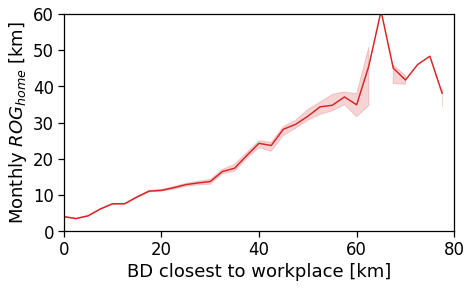

In [94]:
tmp_data = cleaned_user_stats_table_df.copy(deep=True)

fig, ax = compareLinePlot(
            data=tmp_data,
            x_scatter='closest_cbd_dist',
            x_line='closest_cbd_dist_bin',
            y='rog_home',
            xlabel='BD closest to workplace [km]',
            ylabel=r'Monthly $ROG_{home}$ [km]',
            xlim=[0,80],
            ylim=[0,60],
            scatterkws={'alpha': .0},
    )
plt.savefig(os.path.join(OUT_DIR_FIG, 'rogHome_vs_cbd_scatterLine_users_cbd_closest.pdf'))

### Daily ROG

We compute the per-user-day average ROG.

In [95]:
for c in perAreaDailyROG.columns:
    if c in gdf_aoi_grid_landuse:
        del gdf_aoi_grid_landuse[c]
        
gdf_aoi_grid_landuse = pd.merge(gdf_aoi_grid_landuse,
                                 perAreaDailyROG.reset_index(),
                                 on=zidColName,
                                 how='left')

for c in perAreaDailyROG.columns:
    gdf_aoi_grid_landuse[c].fillna(.0, inplace=True)

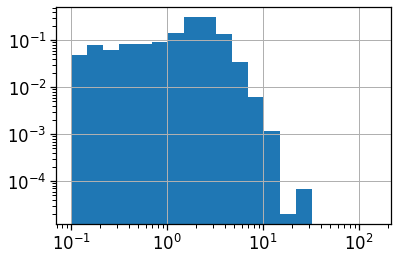

In [96]:
gdf_aoi_grid_landuse['rog_mean'].hist(bins=np.geomspace(.1,150,20),
                                      density=True)
plt.loglog();

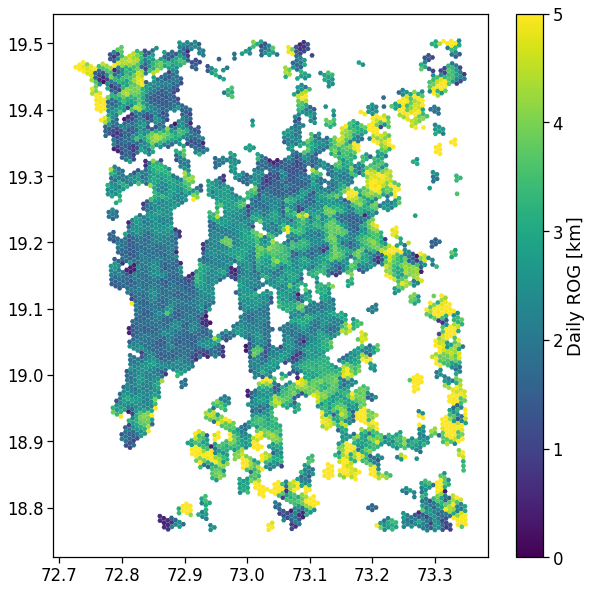

In [97]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
gdf_aoi_grid_landuse.query('rog_mean>0 & rog_count > 100').plot('rog_mean',
                                                                vmin=.0, vmax=5.,
                          legend=True, ax=ax,
                          legend_kwds={'label': r'Daily ROG [km]'})
plt.savefig(os.path.join(OUT_DIR_FIG, 'daily_rog_map.pdf'))

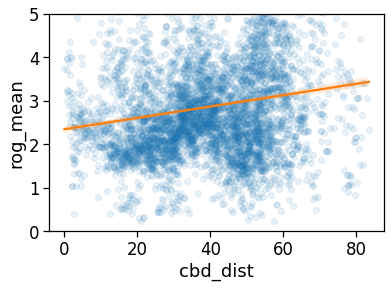

In [98]:
# The same analysis with a 2-degree interpolating line...
sns.regplot(
    x='cbd_dist',
    y='rog_mean',
    data=gdf_aoi_grid_landuse.query('rog_mean>0 & rog_count > 100'),
    line_kws={'color': 'C1'},
    scatter_kws={'alpha':.1},
    order=1,
)
plt.ylim(0,5)
plt.savefig(os.path.join(OUT_DIR_FIG, 'daily_rog_vs_cbd.pdf'))

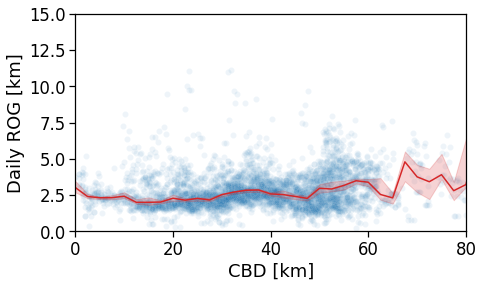

In [99]:
tmp_data = gdf_aoi_grid_landuse.query('rog_mean>0 & rog_count > 200')\
                                .copy(deep=True)
fig, ax = compareLinePlot(
            data=tmp_data,
            x_scatter='cbd_dist',
            x_line='cbd_dist_bin',
            y='rog_mean',
            xlabel='CBD [km]',
            ylabel='Daily ROG [km]',
            xlim=[0,80],
            ylim=[0,15],
    )
plt.savefig(os.path.join(OUT_DIR_FIG, 'daily_rog_vs_cbd_scatterLine.pdf'))

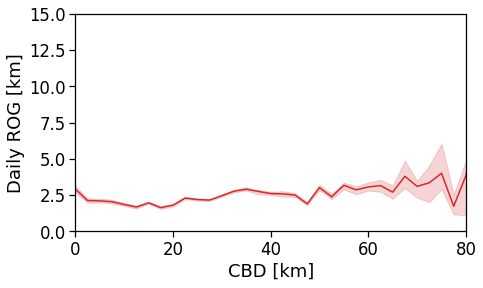

In [100]:
tmp_data = cleaned_user_stats_table_df.copy(deep=True)

fig, ax = compareLinePlot(
            data=tmp_data,
            x_scatter='cbd_dist',
            x_line='cbd_dist_bin',
            y='rog',
            xlabel='CBD [km]',
            ylabel='Daily ROG [km]',
            xlim=[0,80],
            ylim=[0,15],
            doScatter=False,
    )
plt.savefig(os.path.join(OUT_DIR_FIG, 'daily_rog_vs_cbd_scatterLine_user_cbd.pdf'))

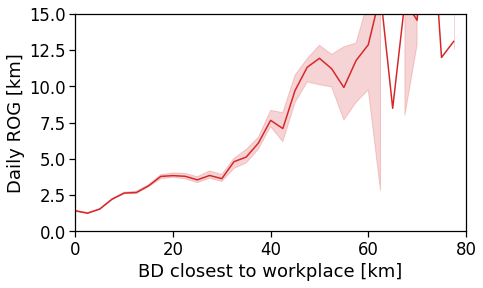

In [101]:
tmp_data = cleaned_user_stats_table_df.copy(deep=True)

fig, ax = compareLinePlot(
            data=tmp_data,
            x_scatter='closest_cbd_dist',
            x_line='closest_cbd_dist_bin',
            y='rog',
            xlabel='BD closest to workplace [km]',
            ylabel='Daily ROG [km]',
            xlim=[0,80],
            ylim=[0,15],
            doScatter=False,
    )
plt.savefig(os.path.join(OUT_DIR_FIG, 'daily_rog_vs_cbd_scatterLine_user_cbd_closest.pdf'))

### Daily total traveled distance

We compute the per-user-day total travel distance.

In [102]:
for c in perAreaDailyTTD.columns:
    if c in gdf_aoi_grid_landuse:
        del gdf_aoi_grid_landuse[c]
        
gdf_aoi_grid_landuse = pd.merge(gdf_aoi_grid_landuse,
                                 perAreaDailyTTD.reset_index(),
                                 on=zidColName,
                                 how='left')

for c in perAreaDailyTTD.columns:
    gdf_aoi_grid_landuse[c].fillna(.0, inplace=True)

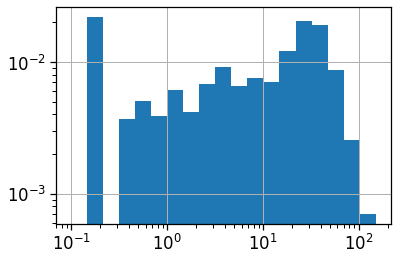

In [103]:
gdf_aoi_grid_landuse['ttd_mean'].hist(bins=np.geomspace(.1,150,20),
                                      density=True)
plt.loglog();

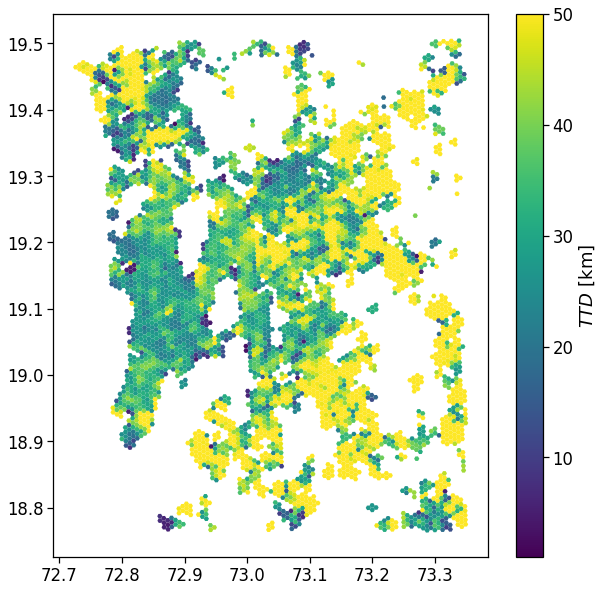

In [104]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
gdf_aoi_grid_landuse.query('ttd_mean>0 & ttd_count > 100').plot('ttd_mean', vmin=1, vmax=50,
                          legend=True, ax=ax,
                          legend_kwds={'label': r'$TTD$ [km]'})
plt.savefig(os.path.join(OUT_DIR_FIG, 'ttd_map.pdf'))

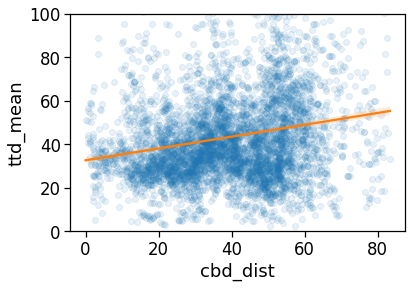

In [105]:
# The same analysis with a 2-degree interpolating line...
sns.regplot(
    x='cbd_dist',
    y='ttd_mean',
    data=gdf_aoi_grid_landuse.query('ttd_mean>0 & ttd_count > 100'),
    line_kws={'color': 'C1'},
    scatter_kws={'alpha':.1},
    order=1,
)
plt.ylim(0,100)
plt.savefig(os.path.join(OUT_DIR_FIG, 'ttd_vs_cbd.pdf'))

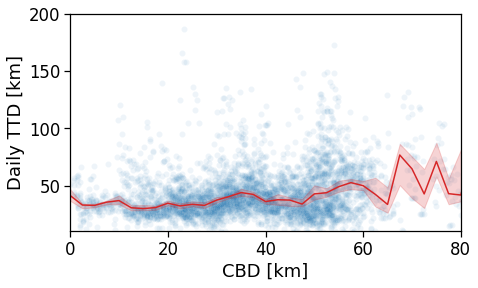

In [106]:
tmp_data = gdf_aoi_grid_landuse.query('ttd_mean>0 & ttd_count > 200')\
                                .copy(deep=True)
fig, ax = compareLinePlot(
            data=tmp_data,
            x_scatter='cbd_dist',
            x_line='cbd_dist_bin',
            y='ttd_mean',
            xlabel='CBD [km]',
            ylabel='Daily TTD [km]',
            xlim=[0,80],
            ylim=[10,200],
    )
plt.savefig(os.path.join(OUT_DIR_FIG, 'ttd_vs_cbd_scatterLine.pdf'))

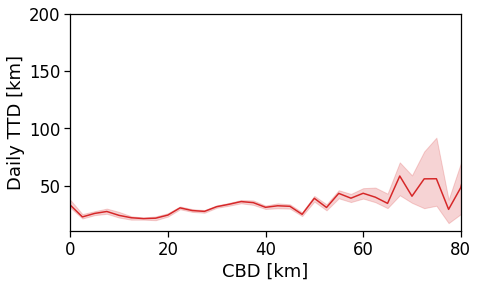

In [107]:
tmp_data = cleaned_user_stats_table_df.copy(deep=True)

fig, ax = compareLinePlot(
            data=tmp_data,
            x_scatter='cbd_dist',
            x_line='cbd_dist_bin',
            y='ttd',
            xlabel='CBD [km]',
            ylabel='Daily TTD [km]',
            xlim=[0,80],
            ylim=[10,200],
            doScatter=False,
    )
plt.savefig(os.path.join(OUT_DIR_FIG, 'ttd_vs_cbd_scatterLine_user_cbd.pdf'))

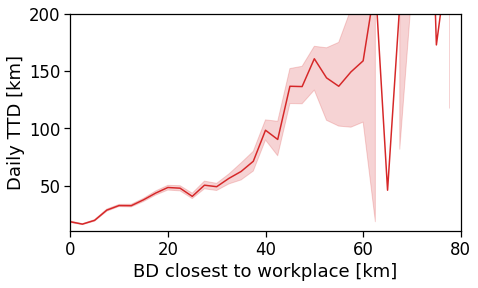

In [108]:
tmp_data = cleaned_user_stats_table_df.copy(deep=True)

fig, ax = compareLinePlot(
            data=tmp_data,
            x_scatter='closest_cbd_dist',
            x_line='closest_cbd_dist_bin',
            y='ttd',
            xlabel='BD closest to workplace [km]',
            ylabel='Daily TTD [km]',
            xlim=[0,80],
            ylim=[10,200],
            doScatter=False,
    )
plt.savefig(os.path.join(OUT_DIR_FIG, 'ttd_vs_cbd_scatterLine_user_cbd_closest.pdf'))

In [109]:
gdf_aoi_grid_landuse.to_file(out_grid_cells_file, driver='GPKG')

### Number of houses/offices

We:
- project the user home/work locations to the local projection given by `local_EPSG`;
- buffer their location by `homeWorkBufferMeters` meters to simulate a kernel density (with flat kernel over a circle);
- count the number of offices and homes found in each cell and compute their absolute ratio;


### Area vocation: ratio of  of houses/offices

We simply compute the per-area $a$ ratio $R_a$ between the density of homes and offices.

To obtain an homogeneous indicator we compute the $log_2$ of this ratio, i.e., 

$$
R_a = \log_2\left(\frac{H_a}{W_a}\right),
$$

where $H_a,\,W_a$ are the number of homes and workplaces found in area $a$, respectively.

A negative value of $R_a$ signals a predominance of workplaces (an area devoted to commercial and business activities), whereas a positive value indicates a more residental-based area. Values $R_a \sim 0$ highlight a balanced mixing of the two.

**NOTE**
>When determining the home location of a user, please consider that some data providers, like Cuebiq, obfuscate/obscure/alter the coordinates of the points falling near the user’s home location in order to preserve privacy.
>
>This means that you cannot locate the precise home of a user with a spatial resolution higher than the one used to obfuscate these data. If you are interested in the census area (or geohash) of the user’s home alone and you are using a spatial tessellation with a spatial resolution wider than or equal to the one used to obfuscate the data, then this is of no concern.
>
>However, tasks such as stop-detection or POI visit rate computation may be affected by the noise added to data in the user’s home location area. Please check if your data has such noise added and choose the spatial tessellation according to your use case.

In [110]:
gdf_aoi_grid_landuse['n_homes'] = gdf_aoi_grid_landuse[zidColName].apply(lambda z: home_counts[z]
                                                                                     if z in home_counts else 0)
gdf_aoi_grid_landuse['n_works'] = gdf_aoi_grid_landuse[zidColName].apply(lambda z: work_counts[z]
                                                                                     if z in work_counts else 0)

gdf_aoi_grid_landuse['home_work_ratio'] = np.log2(gdf_aoi_grid_landuse['n_homes'].clip(lower=1)
                                                / gdf_aoi_grid_landuse['n_works'].clip(lower=1))

gdf_aoi_grid_landuse.loc[
    (gdf_aoi_grid_landuse['n_homes'] < min_pings_home_work)
    | (gdf_aoi_grid_landuse['n_works'] < min_pings_home_work), 'home_work_ratio'] = None
gdf_aoi_grid_landuse.head(0)

Empty GeoDataFrame
Columns: [id, left, top, right, bottom, tile_ID, geometry, cluster, scope, nUsers, rog_total_min, rog_total_max, rog_total_mean, rog_total_std, rog_total_count, rog_home_min, rog_home_max, rog_home_mean, rog_home_std, rog_home_count, cbd_dist, cbd_dist_bin, rog_min, rog_max, rog_mean, rog_std, rog_count, ttd_min, ttd_max, ttd_mean, ttd_std, ttd_count, n_homes, n_works, home_work_ratio]
Index: []

[0 rows x 35 columns]

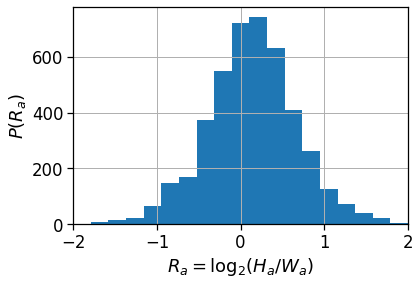

In [111]:
gdf_aoi_grid_landuse['home_work_ratio'].hist(bins=np.linspace(-2,2, 20))
plt.xlabel(r'$R_a = \log_2\left(H_a / W_a\right)$')
plt.ylabel(r'$P(R_a)$')
plt.xlim(-2,2)
plt.savefig(os.path.join(OUT_DIR_FIG, 'home_work_ratio_hist.pdf'))

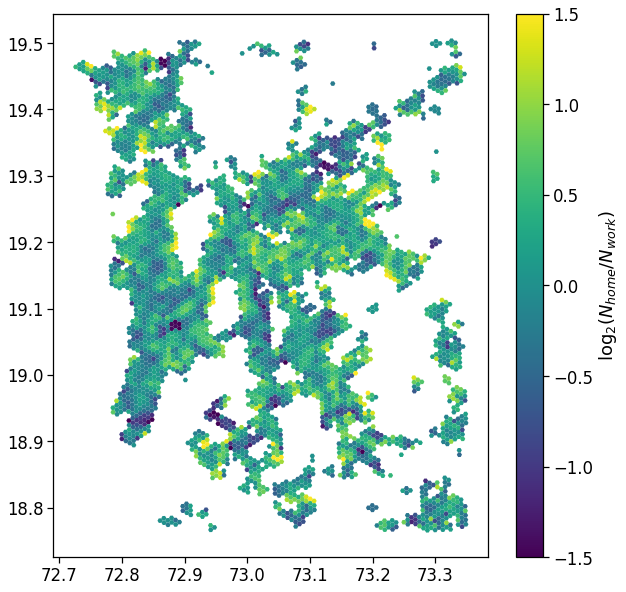

In [112]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
gdf_aoi_grid_landuse.plot('home_work_ratio', vmin=-1.5, vmax=1.5,
                          legend=True, ax=ax,
                          legend_kwds={'label': r'$\log_{2}(N_{home}/N_{work})$'})
plt.savefig(os.path.join(OUT_DIR_FIG, 'home_work_ratio_map.pdf'))

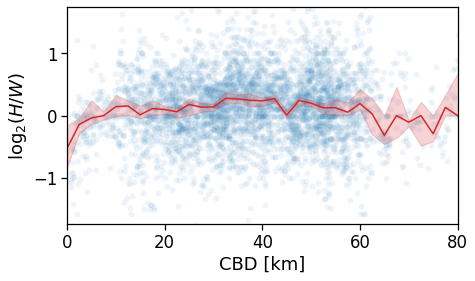

In [113]:
# Check the indicator dependence on the distance from main CBD
tmp_data = gdf_aoi_grid_landuse

fig, ax = compareLinePlot(
            data=tmp_data,
            x_scatter='cbd_dist',
            x_line='cbd_dist_bin',
            y='home_work_ratio',
            xlabel='CBD [km]',
            ylabel=r'$\log_2(H/W)$',
            xlim=[0,80],
            ylim=[-1.75,1.75],
    )
plt.savefig(os.path.join(OUT_DIR_FIG, 'home_work_ratio_scatterLine.pdf'))

In [114]:
gdf_aoi_grid_landuse.to_file(out_grid_cells_file, driver='GPKG')

### Length and duration of commute


In [116]:
gdf_aoi_grid_landuse_trip_stats = pd.merge(gdf_aoi_grid_landuse,
                                time_trips_stats_df[[c for c in time_trips_stats_df.columns if c != uidColName]].reset_index(),
                                on=zidColName, how='outer')

for c in time_trips_stats_df.columns:
    if c != uidColName:
        gdf_aoi_grid_landuse_trip_stats[c] = gdf_aoi_grid_landuse_trip_stats[c].astype(float)

gdf_aoi_grid_landuse_trip_stats.to_file(out_grid_cells_file, driver='GPKG')

### Avg. commute real OSRM distance

We have to transform the output of the OSRM backend from seconds/meters to hours/km to compare them to the measures produced by `mobilkit`.

In [117]:
gdf_aoi_grid_landuse_trip_stats['home_work_osrm_dist_km_avg'] = gdf_aoi_grid_landuse_trip_stats['home_work_osrm_dist_avg'] / 1000.
gdf_aoi_grid_landuse_trip_stats['home_work_osrm_time_h_avg']  = gdf_aoi_grid_landuse_trip_stats['home_work_osrm_time_avg'] / 3600.

user_stats_table_df['home_work_osrm_dist_km'] = user_stats_table_df['home_work_osrm_dist'] / 1000.
user_stats_table_df['home_work_osrm_time_h']  = user_stats_table_df['home_work_osrm_time'] / 3600.

cleaned_user_stats_table_df['home_work_osrm_dist_km'] = cleaned_user_stats_table_df['home_work_osrm_dist'] / 1000.
cleaned_user_stats_table_df['home_work_osrm_time_h']  = cleaned_user_stats_table_df['home_work_osrm_time'] / 3600.

tmp_df_stat = gdf_aoi_grid_landuse_trip_stats.query('n_homes > 15 | n_works > 15')

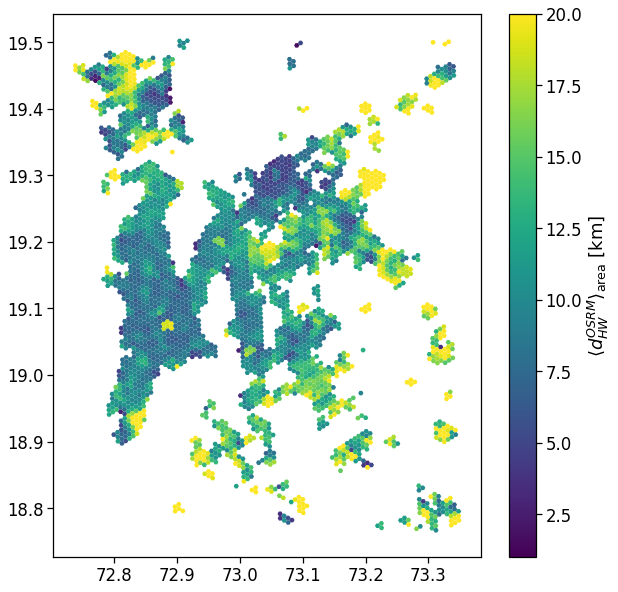

In [118]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
tmp_df_stat.plot('home_work_osrm_dist_km_avg',
                                     vmin=1., vmax=20,
                                     ax=ax, legend=True,
                                     legend_kwds={'label': r'$\langle d^{OSRM}_{HW}\rangle_{\rm area}$ [km]'})
plt.savefig(os.path.join(OUT_DIR_FIG, 'home_work_dist_osrm_map.pdf'))

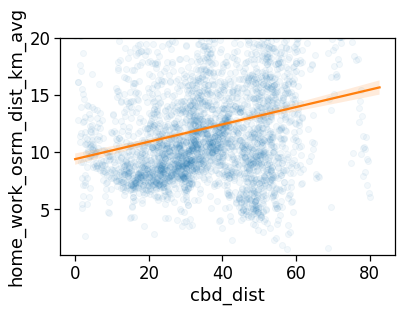

In [119]:
# The same analysis with a 2-degree interpolating line...
sns.regplot(
    x='cbd_dist',
    y='home_work_osrm_dist_km_avg',
    data=tmp_df_stat,
    line_kws={'color': 'C1'},
    scatter_kws={'alpha':.05},
    order=1,
)
plt.ylim(1.,20)
plt.savefig(os.path.join(OUT_DIR_FIG, 'home_work_dist_osrm_scatter.pdf'), bbox_inches='tight')

In [120]:
tmp_data = gdf_aoi_grid_landuse_trip_stats.query('rog_home_count > 20')\
                                .copy(deep=True)

fig, ax = compareLinePlot(
            data=tmp_data,
            x_scatter='cbd_dist',
            x_line='cbd_dist_bin',
            y='home_work_osrm_dist_km_avg',
            xlabel='CBD [km]',
            ylabel=r'$d^{OSRM}_{HW}$ [km]',
            xlim=[0,80],
            ylim=[5,22],
    )
plt.savefig(os.path.join(OUT_DIR_FIG, 'home_work_dist_osrm_scatterLine.pdf'), bbox_inches='tight')

In [121]:
tmp_data = cleaned_user_stats_table_df.copy(deep=True)

fig, ax = compareLinePlot(
            data=tmp_data,
            x_scatter='cbd_dist',
            x_line='cbd_dist_bin',
            y='home_work_osrm_dist_km',
            xlabel='CBD [km]',
            ylabel=r'$d^{OSRM}_{HW}$ [km]',
            xlim=[0,60],
            ylim=[0,20],
            scatterkws={'alpha':0}
    )
plt.savefig(os.path.join(OUT_DIR_FIG, 'home_work_dist_osrm_scatterLine_user_cbd.pdf'), bbox_inches='tight')

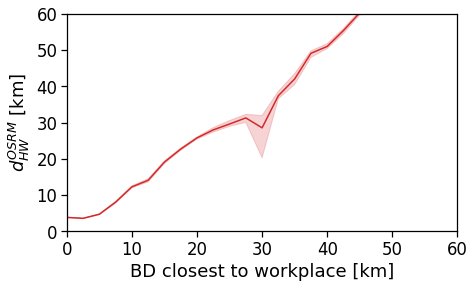

In [122]:
# Check the indicator dependence on the distance from the user's home to closest BD
tmp_data = cleaned_user_stats_table_df.copy(deep=True)

fig, ax = compareLinePlot(
            data=tmp_data,
            x_scatter='closest_cbd_dist',
            x_line='closest_cbd_dist_bin',
            y='home_work_osrm_dist_km',
            xlabel='BD closest to workplace [km]',
            ylabel=r'$d^{OSRM}_{HW}$ [km]',
            xlim=[0,60],
            ylim=[0,60],
            scatterkws={'alpha':0}
    )
plt.savefig(os.path.join(OUT_DIR_FIG, 'home_work_dist_osrm_scatterLine_user_cbd_closest.pdf'), bbox_inches='tight')

### OSRM commute duration

In [123]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
tmp_df_stat.plot('home_work_osrm_time_h_avg',
                                     vmin=.0, vmax=.5,
                                     ax=ax, legend=True,
                                     legend_kwds={'label': r'$\langle T_{OSM}\rangle_{area}$ [h]'}
                                    )
plt.savefig(os.path.join(OUT_DIR_FIG, 'home_work_time_osrm_map.pdf'), bbox_inches='tight')

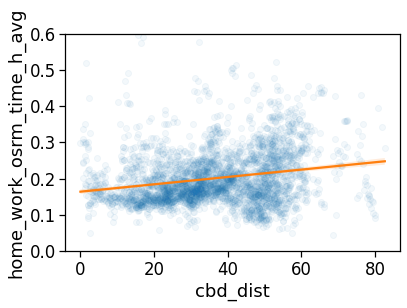

In [124]:
# The same analysis with a 2-degree interpolating line...
sns.regplot(
    x='cbd_dist',
    y='home_work_osrm_time_h_avg',
    data=tmp_df_stat,
    line_kws={'color': 'C1'},
    scatter_kws={'alpha':.05},
    order=1,
)
plt.ylim(0,.6)
plt.savefig(os.path.join(OUT_DIR_FIG, 'home_work_time_osrm_scatter.pdf'), bbox_inches='tight')

In [125]:
tmp_data = gdf_aoi_grid_landuse_trip_stats.query('rog_home_count > 20')\
                                .copy(deep=True)

fig, ax = compareLinePlot(
            data=tmp_data,
            x_scatter='cbd_dist',
            x_line='cbd_dist_bin',
            y='home_work_osrm_time_h_avg',
            xlabel='CBD [km]',
            ylabel=r'$t^{OSRM}_{HW}$ [h]',
            xlim=[0,80],
            ylim=[.1,.4],
    )
plt.savefig(os.path.join(OUT_DIR_FIG, 'home_work_time_osrm_scatterLine.pdf'), bbox_inches='tight')

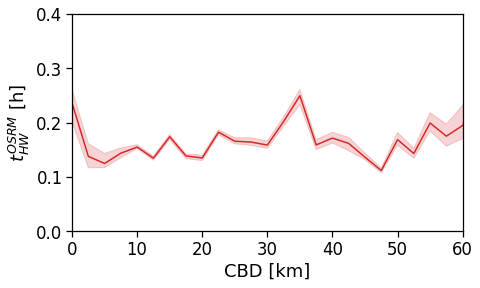

In [126]:
tmp_data = cleaned_user_stats_table_df.copy(deep=True)

fig, ax = compareLinePlot(
            data=tmp_data,
            x_scatter='cbd_dist',
            x_line='cbd_dist_bin',
            y='home_work_osrm_time_h',
            xlabel='CBD [km]',
            ylabel=r'$t^{OSRM}_{HW}$ [h]',
            xlim=[0,60],
            ylim=[.0,.4],
            scatterkws={'alpha':0}
    )
plt.savefig(os.path.join(OUT_DIR_FIG, 'home_work_time_osrm_scatterLine_user_cbd.pdf'), bbox_inches='tight')

In [127]:
tmp_data = cleaned_user_stats_table_df.copy(deep=True)

fig, ax = compareLinePlot(
            data=tmp_data,
            x_scatter='closest_cbd_dist',
            x_line='closest_cbd_dist_bin',
            y='home_work_osrm_time_h',
            xlabel='BD closest to workplace [km]',
            ylabel=r'$t^{OSRM}_{HW}$ [h]',
            xlim=[0,60],
            ylim=[.0,1.5],
            scatterkws={'alpha':0}
    )
plt.savefig(os.path.join(OUT_DIR_FIG, 'home_work_time_osrm_scatterLine_user_cbd_closest.pdf'), bbox_inches='tight')

### Avg. commute real duration

In [128]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
tmp_df_stat.plot('time_trips_hw_avg',
                                     vmin=1., vmax=2.5,
                                     ax=ax, legend=True,
                                     legend_kwds={'label': r'$\langle T_{HW}\rangle_{\rm area}$ [h]'})
plt.savefig(os.path.join(OUT_DIR_FIG, 'home_work_time_real_map.pdf'), bbox_inches='tight')

In [129]:
# The same analysis with a 2-degree interpolating line...
sns.regplot(
    x='cbd_dist',
    y='time_trips_hw_avg',
    data=tmp_df_stat,
    line_kws={'color': 'C1'},
    scatter_kws={'alpha':.05},
    order=1,
)
plt.ylim(1.5,2.75)
plt.savefig(os.path.join(OUT_DIR_FIG, 'home_work_time_real_scatter.pdf'), bbox_inches='tight')

In [130]:
# Linear interpolation of rog vs distance...
x_col = 'cbd_dist'
y_col = 'time_trips_hw_avg'

tmp_data = tmp_df_stat[[x_col, y_col]].dropna()

model = sm.GLS(tmp_data[y_col], tmp_data[x_col])
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 GLS Regression Results                                
=======================================================================================
Dep. Variable:      time_trips_hw_avg   R-squared (uncentered):                   0.827
Model:                            GLS   Adj. R-squared (uncentered):              0.827
Method:                 Least Squares   F-statistic:                          1.558e+04
Date:                Mon, 16 May 2022   Prob (F-statistic):                        0.00
Time:                        15:53:33   Log-Likelihood:                         -3828.6
No. Observations:                3256   AIC:                                      7659.
Df Residuals:                    3255   BIC:                                      7665.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cbd_dist       0.0435      0.000    124.812      0.000       0.043       0.044
==============================================================================
Omnibus:                       23.276   Durbin-Watson:                   0.335
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.370
Skew:                          -0.101   Prob(JB):                     2.54e-07
Kurtosis:                       3.427   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

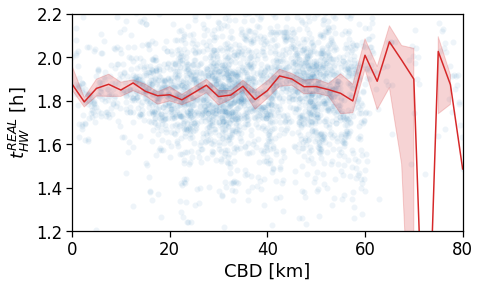

In [131]:
tmp_data = gdf_aoi_grid_landuse_trip_stats.query('rog_home_count > 20')\
                                .copy(deep=True)

fig, ax = compareLinePlot(
            data=tmp_data,
            x_scatter='cbd_dist',
            x_line='cbd_dist_bin',
            y='time_trips_hw_avg',
            xlabel='CBD [km]',
            ylabel=r'$t^{REAL}_{HW}$ [h]',
            xlim=[0,80],
            ylim=[1.2,2.2],
    )
plt.savefig(os.path.join(OUT_DIR_FIG, 'home_work_time_real_scatterLine.pdf'), bbox_inches='tight')

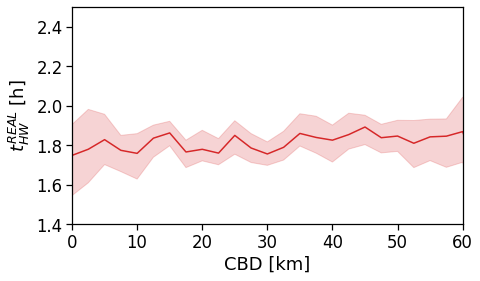

In [132]:
tmp_data = cleaned_user_stats_table_df.copy(deep=True)

fig, ax = compareLinePlot(
            data=tmp_data,
            x_scatter='cbd_dist',
            x_line='cbd_dist_bin',
            y='time_trips_hw',
            xlabel='CBD [km]',
            ylabel=r'$t^{REAL}_{HW}$ [h]',
            xlim=[0,60],
            ylim=[1.4,2.5],
            scatterkws={'alpha':0}
    )
plt.savefig(os.path.join(OUT_DIR_FIG, 'home_work_time_real_scatterLine_user_cbd.pdf'), bbox_inches='tight')

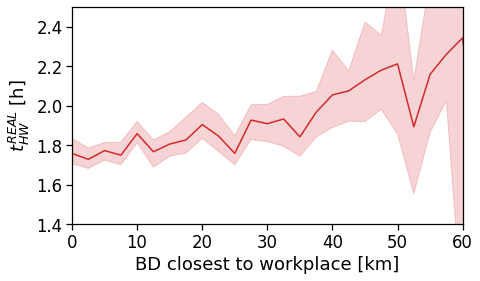

In [133]:
tmp_data = cleaned_user_stats_table_df.copy(deep=True)

fig, ax = compareLinePlot(
            data=tmp_data,
            x_scatter='closest_cbd_dist',
            x_line='closest_cbd_dist_bin',
            y='time_trips_hw',
            xlabel='BD closest to workplace [km]',
            ylabel=r'$t^{REAL}_{HW}$ [h]',
            xlim=[0,60],
            ylim=[1.4,2.5],
            scatterkws={'alpha':0}
    )
plt.savefig(os.path.join(OUT_DIR_FIG, 'home_work_time_real_scatterLine_user_cbd_closest.pdf'), bbox_inches='tight')

### Avg. commute real speed

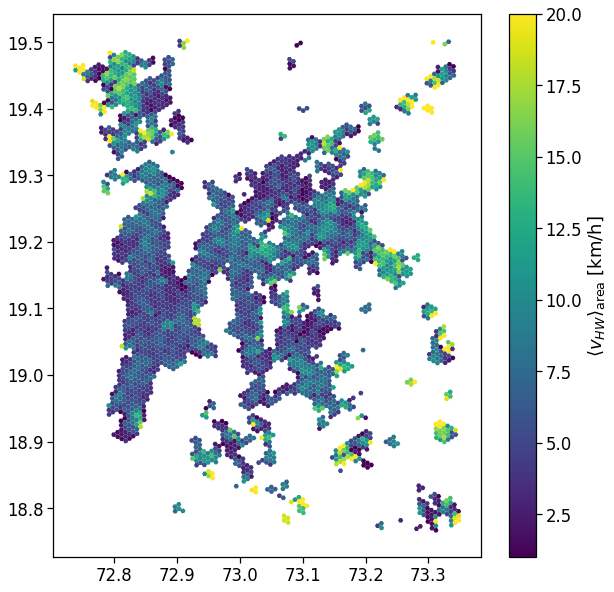

In [134]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
tmp_df_stat.plot('speed_trips_hw_avg',
                                     vmin=1., vmax=20,
                                     ax=ax, legend=True,
                                     legend_kwds={'label': r'$\langle v_{HW}\rangle_{\rm area}$ [km/h]'})
plt.savefig(os.path.join(OUT_DIR_FIG, 'home_work_speed_real_map.pdf'), bbox_inches='tight')

In [135]:
tmp_df_stat.speed_trips_hw_avg.describe()

count    3256.000000
mean        7.236964
std         4.947375
min         0.062201
25%         4.257395
50%         6.173521
75%         8.896125
max        86.212988
Name: speed_trips_hw_avg, dtype: float64

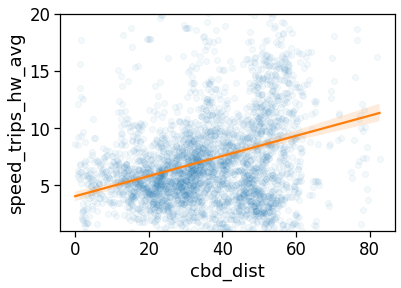

In [136]:
# The same analysis with a 2-degree interpolating line...
sns.regplot(
    x='cbd_dist',
    y='speed_trips_hw_avg',
    data=tmp_df_stat,
    line_kws={'color': 'C1'},
    scatter_kws={'alpha':.05},
    order=1,
)
plt.ylim(1.,20)
plt.savefig(os.path.join(OUT_DIR_FIG, 'home_work_speed_real_scatter.pdf'), bbox_inches='tight')

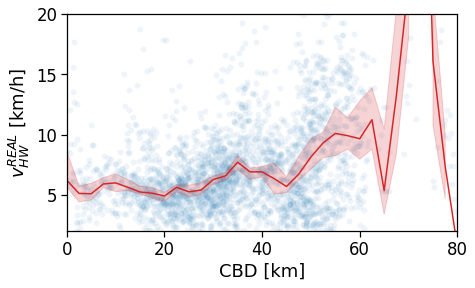

In [137]:
tmp_data = gdf_aoi_grid_landuse_trip_stats.query('rog_home_count > 20')\
                                .copy(deep=True)

fig, ax = compareLinePlot(
            data=tmp_data,
            x_scatter='cbd_dist',
            x_line='cbd_dist_bin',
            y='speed_trips_hw_avg',
            xlabel='CBD [km]',
            ylabel=r'$v^{REAL}_{HW}$ [km/h]',
            xlim=[0,80],
            ylim=[2,20],
    )
plt.savefig(os.path.join(OUT_DIR_FIG, 'home_work_speed_real_scatterLine.pdf'), bbox_inches='tight')

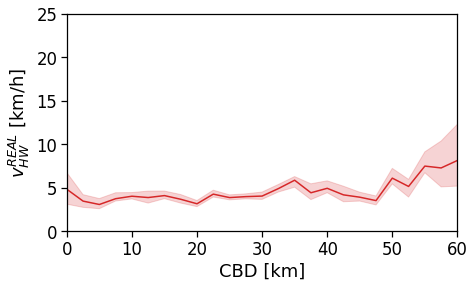

In [138]:
tmp_data = cleaned_user_stats_table_df.copy(deep=True)

fig, ax = compareLinePlot(
            data=tmp_data,
            x_scatter='cbd_dist',
            x_line='cbd_dist_bin',
            y='speed_trips_hw',
            xlabel='CBD [km]',
            ylabel=r'$v^{REAL}_{HW}$ [km/h]',
            xlim=[0,60],
            ylim=[0,25],
            scatterkws={'alpha': 0}
    )
plt.savefig(os.path.join(OUT_DIR_FIG, 'home_work_speed_real_scatterLine_user_cbd.pdf'), bbox_inches='tight')

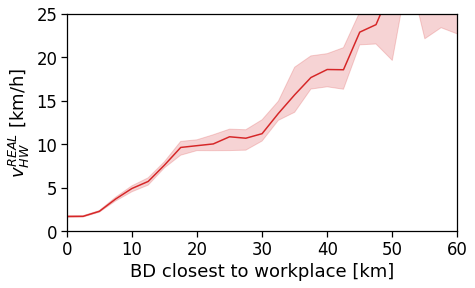

In [139]:
tmp_data = cleaned_user_stats_table_df.copy(deep=True)

fig, ax = compareLinePlot(
            data=tmp_data,
            x_scatter='closest_cbd_dist',
            x_line='closest_cbd_dist_bin',
            y='speed_trips_hw',
            xlabel='BD closest to workplace [km]',
            ylabel=r'$v^{REAL}_{HW}$ [km/h]',
            xlim=[0,60],
            ylim=[0,25],
            scatterkws={'alpha': 0}
    )
plt.savefig(os.path.join(OUT_DIR_FIG, 'home_work_speed_real_scatterLine_user_cbd_closest.pdf'), bbox_inches='tight')

### Real commuting duration / traffic-free OSRM driving duration

This is an indicator of congestions and/or lack of street infrastructure performance, as a ratio >> 1 indicates longer commuting times. 

In [140]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
tmp_df_stat.plot('avg_realT_frac_osmT',
                                     vmin=.5, vmax=15,
                                     ax=ax, legend=True,
                                     legend_kwds={'label': r'$T_{real}/T_{OSM}$'}
                                    )
plt.savefig(os.path.join(OUT_DIR_FIG, 'home_work_time_real_frac_time_OSRM_map.pdf'), bbox_inches='tight')

In [141]:
# The same analysis with a 2-degree interpolating line...
sns.regplot(
    x='cbd_dist',
    y='avg_realT_frac_osmT',
    data=tmp_df_stat,
    line_kws={'color': 'C1'},
    scatter_kws={'alpha':.05},
    order=1,
)
plt.ylim(0,20)
plt.savefig(os.path.join(OUT_DIR_FIG, 'home_work_time_real_frac_time_OSRM_scatter.pdf'), bbox_inches='tight')

In [142]:
tmp_data = gdf_aoi_grid_landuse_trip_stats.query('rog_home_count > 20')\
                                .copy(deep=True)

fig, ax = compareLinePlot(
            data=tmp_data,
            x_scatter='cbd_dist',
            x_line='cbd_dist_bin',
            y='avg_realT_frac_osmT',
            xlabel='CBD [km]',
            ylabel=r'$t^{REAL}_{HW} / t^{OSRM}_{HW}$',
            xlim=[0,80],
            ylim=[2,20],
    )
plt.savefig(os.path.join(OUT_DIR_FIG, 'home_work_time_real_frac_time_OSRM_scatterLine.pdf'), bbox_inches='tight')

As for the speed of commuting, we observe no clear signal in the congestion rate when we consider the single CBD.

In [143]:
tmp_data = cleaned_user_stats_table_df.copy(deep=True)

fig, ax = compareLinePlot(
            data=tmp_data,
            x_scatter='cbd_dist',
            x_line='cbd_dist_bin',
            y='avg_realT_frac_osmT',
            xlabel='CBD [km]',
            ylabel=r'$t^{REAL}_{HW} / t^{OSRM}_{HW}$',
            xlim=[0,80],
            ylim=[2,20],
            scatterkws={'alpha': .0}
    )
plt.savefig(os.path.join(OUT_DIR_FIG, 'home_work_time_real_frac_time_OSRM_scatterLine_user_cbd.pdf'), bbox_inches='tight')

However, once the BD closest to user's workplace is consideres, a clear pattern emerges: BD are always congested resulting in slower commuting.

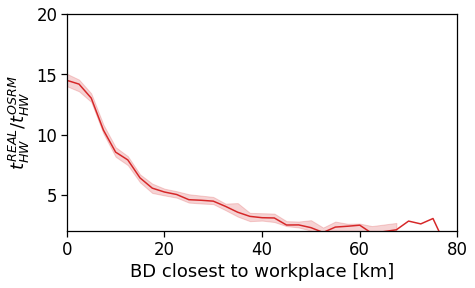

In [144]:
tmp_data = cleaned_user_stats_table_df.copy(deep=True)

fig, ax = compareLinePlot(
            data=tmp_data,
            x_scatter='closest_cbd_dist',
            x_line='closest_cbd_dist_bin',
            y='avg_realT_frac_osmT',
            xlabel='BD closest to workplace [km]',
            ylabel=r'$t^{REAL}_{HW} / t^{OSRM}_{HW}$',
            xlim=[0,80],
            ylim=[2,20],
            scatterkws={'alpha': .0}
    )
plt.savefig(os.path.join(OUT_DIR_FIG, 'home_work_time_real_frac_time_OSRM_scatterLine_user_cbd_closest.pdf'), bbox_inches='tight')

### Avg. commute straight distance

In [145]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
tmp_df_stat.plot('home_work_straight_dist_avg',
                                     vmin=1., vmax=20,
                                     ax=ax, legend=True,
                                     legend_kwds={'label': r'$\langle d_{HW}\rangle_{\rm area}$ [km]'})
plt.savefig(os.path.join(OUT_DIR_FIG, 'home_work_time_straight_dist_map.pdf'), bbox_inches='tight')

In [146]:
# The same analysis with a 2-degree interpolating line...
sns.regplot(
    x='cbd_dist',
    y='home_work_straight_dist_avg',
    data=tmp_df_stat,
    line_kws={'color': 'C1'},
    scatter_kws={'alpha':.05},
    order=1,
)
plt.ylim(1.,20)
plt.savefig(os.path.join(OUT_DIR_FIG, 'home_work_time_straight_dist_scatter.pdf'), bbox_inches='tight')

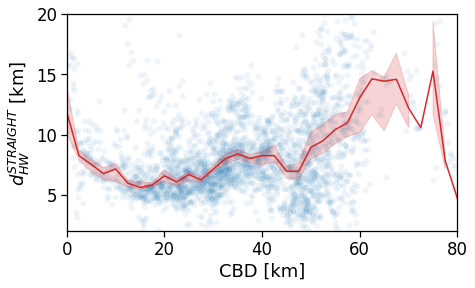

In [147]:
tmp_data = gdf_aoi_grid_landuse_trip_stats.query('rog_home_count > 20')\
                                .copy(deep=True)

fig, ax = compareLinePlot(
            data=tmp_data,
            x_scatter='cbd_dist',
            x_line='cbd_dist_bin',
            y='home_work_straight_dist_avg',
            xlabel='CBD [km]',
            ylabel=r'$d^{STRAIGHT}_{HW}$ [km]',
            xlim=[0,80],
            ylim=[2,20],
    )
plt.savefig(os.path.join(OUT_DIR_FIG, 'home_work_time_straight_dist_scatterLine.pdf'), bbox_inches='tight')

In [148]:
tmp_data = cleaned_user_stats_table_df.copy(deep=True)

fig, ax = compareLinePlot(
            data=tmp_data,
            x_scatter='cbd_dist',
            x_line='cbd_dist_bin',
            y='home_work_straight_dist',
            xlabel='CBD [km]',
            ylabel=r'$d^{STRAIGHT}_{HW}$ [km]',
            xlim=[0,60],
            ylim=[0,45],
            scatterkws={'alpha':0}
    )
plt.savefig(os.path.join(OUT_DIR_FIG, 'home_work_time_straight_dist_scatterLine_user_cbd.pdf'), bbox_inches='tight')

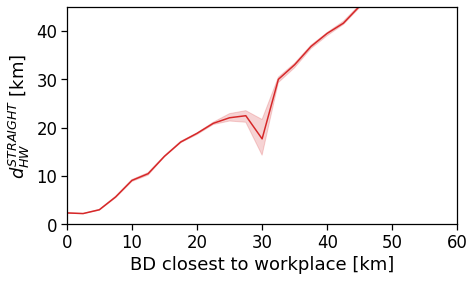

In [149]:
tmp_data = cleaned_user_stats_table_df.copy(deep=True)

fig, ax = compareLinePlot(
            data=tmp_data,
            x_scatter='closest_cbd_dist',
            x_line='closest_cbd_dist_bin',
            y='home_work_straight_dist',
            xlabel='BD closest to workplace [km]',
            ylabel=r'$d^{STRAIGHT}_{HW}$ [km]',
            xlim=[0,60],
            ylim=[0,45],
            scatterkws={'alpha':0}
    )
plt.savefig(os.path.join(OUT_DIR_FIG, 'home_work_time_straight_dist_scatterLine_user_cbd_closest.pdf'), bbox_inches='tight')

### Real distance / straight distance 

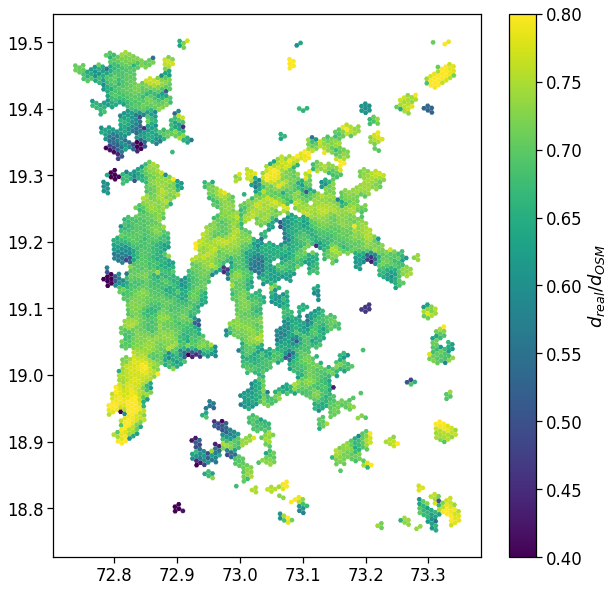

In [150]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
tmp_df_stat.plot('avg_realD_frac_osmD',
                                     vmin=.4, vmax=.8,
                                     ax=ax, legend=True,
                                     legend_kwds={'label': r'$d_{real}/d_{OSM}$'}
                                    )
plt.savefig(os.path.join(OUT_DIR_FIG, 'home_work_dist_real_frac_dist_OSRM_map.pdf'), bbox_inches='tight')

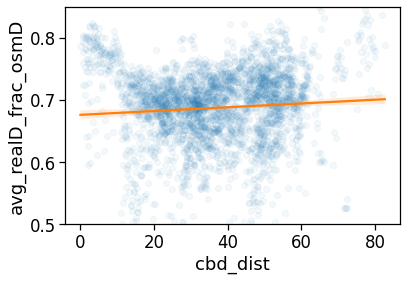

In [151]:
# The same analysis with a 2-degree interpolating line...
sns.regplot(
    x='cbd_dist',
    y='avg_realD_frac_osmD',
    data=tmp_df_stat,
    line_kws={'color': 'C1'},
    scatter_kws={'alpha':.05},
    order=1,
)
plt.ylim(.5,.85)
plt.savefig(os.path.join(OUT_DIR_FIG, 'home_work_dist_real_frac_dist_OSRM_scatter.pdf'), bbox_inches='tight')

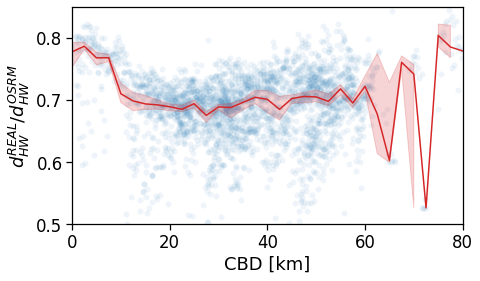

In [152]:
tmp_data = gdf_aoi_grid_landuse_trip_stats.query('rog_home_count > 20')\
                                .copy(deep=True)

fig, ax = compareLinePlot(
            data=tmp_data,
            x_scatter='cbd_dist',
            x_line='cbd_dist_bin',
            y='avg_realD_frac_osmD',
            xlabel='CBD [km]',
            ylabel=r'$d^{REAL}_{HW} / d^{OSRM}_{HW}$',
            xlim=[0,80],
            ylim=[.5,.85],
    )
plt.savefig(os.path.join(OUT_DIR_FIG, 'home_work_dist_real_frac_dist_OSRM_scatterLine.pdf'), bbox_inches='tight')

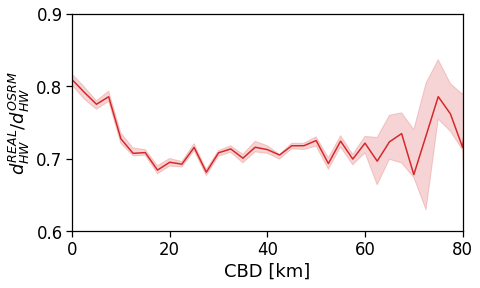

In [153]:
tmp_data = cleaned_user_stats_table_df.copy(deep=True)

fig, ax = compareLinePlot(
            data=tmp_data,
            x_scatter='cbd_dist',
            x_line='cbd_dist_bin',
            y='avg_realD_frac_osmD',
            xlabel='CBD [km]',
            ylabel=r'$d^{REAL}_{HW} / d^{OSRM}_{HW}$',
            xlim=[0,80],
            ylim=[.6,.9],
            scatterkws={'alpha': 0}
    )
plt.savefig(os.path.join(OUT_DIR_FIG, 'home_work_dist_real_frac_dist_OSRM_scatterLine_user_cbd.pdf'), bbox_inches='tight')

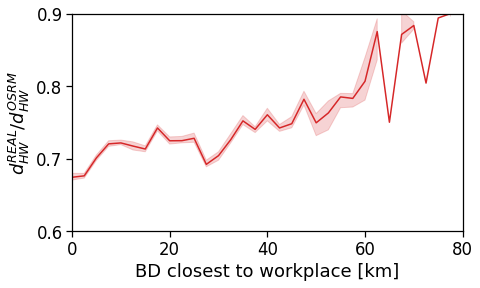

In [154]:
tmp_data = cleaned_user_stats_table_df.copy(deep=True)

fig, ax = compareLinePlot(
            data=tmp_data,
            x_scatter='closest_cbd_dist',
            x_line='closest_cbd_dist_bin',
            y='avg_realD_frac_osmD',
            xlabel='BD closest to workplace [km]',
            ylabel=r'$d^{REAL}_{HW} / d^{OSRM}_{HW}$',
            xlim=[0,80],
            ylim=[.6,.9],
            scatterkws={'alpha': 0}
    )
plt.savefig(os.path.join(OUT_DIR_FIG, 'home_work_dist_real_frac_dist_OSRM_scatterLine_user_cbd_closest.pdf'), bbox_inches='tight')

In [155]:
pd.to_pickle(user_stats_table_df,
            os.path.join(OUT_DIR,  'user_stats_table_df.pkl'))
pd.to_pickle(cleaned_user_stats_table_df,
            os.path.join(OUT_DIR,  'cleaned_user_stats_table_df.pkl'))

## Supplementary info

### Alternative way for home and work location
By looking at the single pings.

In [156]:
dd_dayNight_pings = mk.stats.userHomeWork(exploded_stops_df,
                                                homeHours=homeHours,
                                                workHours=workHours)
df_hw_locs = mk.stats.userHomeWorkLocation(dd_dayNight_pings, force_different=True)
df_hw_locs

Dask DataFrame Structure:
                tot_pings home_tile_ID lat_home lng_home home_pings work_tile_ID lat_work lng_work work_pings
npartitions=200                                                                                              
                    int64        int64  float64  float64      int64        int64  float64  float64      int64
                      ...          ...      ...      ...        ...          ...      ...      ...        ...
...                   ...          ...      ...      ...        ...          ...      ...      ...        ...
                      ...          ...      ...      ...        ...          ...      ...      ...        ...
                      ...          ...      ...      ...        ...          ...      ...      ...        ...
Dask Name: determine_home_work_user, 23885 tasks